# Data preparation

In [ ]:
import numpy as np
import scipy.io as sio
from sklearn.preprocessing import MinMaxScaler
import glob
from tqdm import tqdm
from scipy.signal import butter, filtfilt
import os

num_test_participants = 16

def butter_bandpass(lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return b, a

def apply_bandpass_filter(data, lowcut=20, highcut=400, fs=2000, order=4):
    b, a = butter_bandpass(lowcut, highcut, fs, order)
    n_channels = data.shape[-1]
    filtered_data = np.zeros_like(data)

    # Apply filter to each channel
    for channel in range(n_channels):
        filtered_data[..., channel] = filtfilt(b, a, data[..., channel])

    return filtered_data

def segment_signals(emg_data, movement_labels, repetition_labels, window_size=600, stride=300):

    segments = []
    labels = []

    for i in range(0, len(emg_data) - window_size + 1, stride):
        segment = emg_data[i:i + window_size]
        # Only keep segments that belong to same movement and repetition
        if len(np.unique(movement_labels[i:i + window_size])) == 1 and \
           len(np.unique(repetition_labels[i:i + window_size])) == 1:
            segments.append(segment)
            labels.append(movement_labels[i])

    return np.array(segments), np.array(labels)

def load_ninapro_data(data_dir):
    """
    Load and preprocess NinaPro EMG data
    """
    healthy_data = []
    amputee_data = []

    print("Loading and preprocessing data...")
    mat_files = glob.glob(os.path.join(data_dir, '*.mat'))
    print(f"Found {len(mat_files)} .mat files")

    for file_path in tqdm(mat_files):
        try:
            # Load .mat file
            data = sio.loadmat(file_path)
            subject_id = int(os.path.basename(file_path).split('_')[0][1:])
            print(f"\nProcessing subject {subject_id}")

            # Extract data
            emg_data = data['emg']
            restimulus = data['restimulus'].flatten()
            rerepetition = data['rerepetition'].flatten()

            print(f"EMG data shape: {emg_data.shape}")
            print(f"Unique movements: {np.unique(restimulus[restimulus != 0])}")
            print(f"Number of repetitions: {len(np.unique(rerepetition[rerepetition != 0]))}")

            # Apply bandpass filtering to entire EMG signal first
            emg_data = apply_bandpass_filter(emg_data, lowcut=10, highcut=500, fs=2000)

            # Process each movement separately
            unique_movements = np.unique(restimulus[restimulus != 0])

            for movement in unique_movements:
                # Get data for specific movement
                movement_segments = []
                movement_labels = []

                for rep in range(1, 7):  # 6 repetitions per movement
                    # Get indices for current movement and repetition
                    movement_mask = (restimulus == movement) & (rerepetition == rep)

                    if np.sum(movement_mask) > 0:
                        movement_data = emg_data[movement_mask]
                        print(f"Movement {movement}, Rep {rep}: Found {len(movement_data)} samples")

                        # Segment the movement data
                        segments, labels = segment_signals(
                            movement_data,
                            np.ones_like(movement_mask[movement_mask]) * movement,
                            np.ones_like(movement_mask[movement_mask]) * rep
                        )

                        if len(segments) > 0:
                            movement_segments.append(segments)
                            movement_labels.append(labels)
                            print(f"Created {len(segments)} segments")

                if len(movement_segments) > 0:
                    segments = np.concatenate(movement_segments, axis=0)
                    labels = np.concatenate(movement_labels, axis=0)

                    print(f"Total segments for movement {movement}: {len(segments)}")

                    # Store data based on subject type (healthy vs amputee)
                    if subject_id <= 20:
                        healthy_data.append({
                            'subject_id': subject_id,
                            'movement': movement,
                            'segments': segments,
                            'labels': labels
                        })
                        print(f"Added to healthy data")
                    else:
                        amputee_data.append({
                            'subject_id': subject_id,
                            'movement': movement,
                            'segments': segments,
                            'labels': labels
                        })
                        print(f"Added to amputee data")

        except Exception as e:
            print(f"Error processing file {file_path}: {str(e)}")
            continue

    print(f"\nFinal data summary:")
    print(f"Number of healthy data entries: {len(healthy_data)}")
    print(f"Number of amputee data entries: {len(amputee_data)}")

    if len(healthy_data) > 0:
        print(f"Sample healthy data shape: {healthy_data[0]['segments'].shape}")
    if len(amputee_data) > 0:
        print(f"Sample amputee data shape: {amputee_data[0]['segments'].shape}")

    return process_dataset(healthy_data, amputee_data)

def process_dataset(healthy_data, amputee_data):
    processed_healthy = []
    processed_amputee = []

    # Process healthy subjects (per movement)
    for subject_data in healthy_data:
        segments = subject_data['segments']
        labels = subject_data['labels']

        # Normalize per movement
        scaler = MinMaxScaler(feature_range=(-1, 1))
        segments_reshaped = segments.reshape(-1, segments.shape[-1])
        segments_normalized = scaler.fit_transform(segments_reshaped)
        segments_normalized = segments_normalized.reshape(segments.shape)

        processed_healthy.append({
            'subject_id': subject_data['subject_id'],
            'movement': subject_data['movement'],
            'segments': segments_normalized,
            'labels': labels
        })

    # Process amputee subjects (per movement)
    for subject_data in amputee_data:
        segments = subject_data['segments']
        labels = subject_data['labels']

        scaler = MinMaxScaler(feature_range=(-1, 1))
        segments_reshaped = segments.reshape(-1, segments.shape[-1])
        segments_normalized = scaler.fit_transform(segments_reshaped)
        segments_normalized = segments_normalized.reshape(segments.shape)

        processed_amputee.append({
            'subject_id': subject_data['subject_id'],
            'movement': subject_data['movement'],
            'segments': segments_normalized,
            'labels': labels
        })

    return {
        'healthy_data': processed_healthy,
        'amputee_data': processed_amputee
    }

def prepare_gan_training_data(processed_data, movement_idx=None):

    healthy_data = processed_data['healthy_data']
    amputee_data = processed_data['amputee_data']

    # Split data based on movement if specified
    if movement_idx is not None:
        healthy_movement_data = [d['segments'] for d in healthy_data if d['movement'] == movement_idx]
        amputee_movement_data = [d['segments'] for d in amputee_data if d['movement'] == movement_idx]

        movement_str = f"for movement {movement_idx}"
    else:
        healthy_movement_data = [d['segments'] for d in healthy_data]
        amputee_movement_data = [d['segments'] for d in amputee_data]

        movement_str = "for all movements"

    # Combine segments
    X_train = np.concatenate(healthy_movement_data, axis=0) if healthy_movement_data else np.array([])
    X_test = np.concatenate(amputee_movement_data, axis=0) if amputee_movement_data else np.array([])

    # Get subject IDs for reference
    train_subjects = sorted(list(set([d['subject_id'] for d in healthy_data])))
    test_subjects = sorted(list(set([d['subject_id'] for d in amputee_data])))

    print(f"\nData split summary {movement_str}:")
    print(f"Training (Healthy) subjects: {train_subjects}")
    print(f"Testing (Amputee) subjects: {test_subjects}")
    print(f"\nTraining segments: {X_train.shape[0]} from {len(train_subjects)} healthy subjects")
    print(f"Testing segments: {X_test.shape[0]} from {len(test_subjects)} amputee subjects")
    print(f"Segment shape: {X_train.shape[1:]}")

    return {
        'X_train': X_train,
        'X_test': X_test,
        'train_subjects': train_subjects,
        'test_subjects': test_subjects
    }

def analyze_data_splits(data_splits):
    X_train = data_splits['X_train']
    X_test = data_splits['X_test']

    print("\nDetailed Data Analysis:")
    print("-" * 50)

    print(f"\nTraining (Healthy) Subjects: {data_splits['train_subjects']}")
    print(f"Testing (Amputee) Subjects: {data_splits['test_subjects']}")

    print("\nTraining Data (Healthy):")
    print(f"Shape: {X_train.shape}")
    print(f"Mean: {X_train.mean():.3f}")
    print(f"Std: {X_train.std():.3f}")
    print(f"Min: {X_train.min():.3f}")
    print(f"Max: {X_train.max():.3f}")

    print("\nTest Data (Amputee):")
    print(f"Shape: {X_test.shape}")
    print(f"Mean: {X_test.mean():.3f}")
    print(f"Std: {X_test.std():.3f}")
    print(f"Min: {X_test.min():.3f}")
    print(f"Max: {X_test.max():.3f}")




In [ ]:
data_dir = "Desktop/EMG"

# Load and preprocess all data
processed_data = load_ninapro_data(data_dir)

Loading and preprocessing data...
Found 44 .mat files


  0%|                                                    | 0/44 [00:00<?, ?it/s]


Processing subject 4
EMG data shape: (1798063, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 12996 samples
Created 42 segments
Movement 1, Rep 2: Found 13035 samples
Created 42 segments
Movement 1, Rep 3: Found 13000 samples
Created 42 segments
Movement 1, Rep 4: Found 12777 samples
Created 41 segments
Movement 1, Rep 5: Found 12996 samples
Created 42 segments
Movement 1, Rep 6: Found 13002 samples
Created 42 segments
Total segments for movement 1: 251
Added to healthy data
Movement 2, Rep 1: Found 12989 samples
Created 42 segments
Movement 2, Rep 2: Found 12835 samples
Created 41 segments
Movement 2, Rep 3: Found 12942 samples
Created 42 segments
Movement 2, Rep 4: Found 13006 samples
Created 42 segments
Movement 2, Rep 5: Found 12774 samples
Created 41 segments
Movement 2, Rep 6: Found 13001 samples
Created 42 segments
Total segments for movement 2: 250
Added to healthy data
Movement 3, Rep 1: Found 12539

  2%|█                                           | 1/44 [00:03<02:33,  3.57s/it]

Created 30 segments
Total segments for movement 10: 161
Added to healthy data
Movement 11, Rep 1: Found 11154 samples
Created 36 segments
Movement 11, Rep 2: Found 10907 samples
Created 35 segments
Movement 11, Rep 3: Found 9025 samples
Created 29 segments
Movement 11, Rep 4: Found 12494 samples
Created 40 segments
Movement 11, Rep 5: Found 9249 samples
Created 29 segments
Movement 11, Rep 6: Found 10083 samples
Created 32 segments
Total segments for movement 11: 201
Added to healthy data
Movement 12, Rep 1: Found 7862 samples
Created 25 segments
Movement 12, Rep 2: Found 7500 samples
Created 24 segments
Movement 12, Rep 3: Found 7272 samples
Created 23 segments
Movement 12, Rep 4: Found 7251 samples
Created 23 segments
Movement 12, Rep 5: Found 6021 samples
Created 19 segments
Movement 12, Rep 6: Found 7060 samples
Created 22 segments
Total segments for movement 12: 136
Added to healthy data
Movement 13, Rep 1: Found 7180 samples
Created 22 segments
Movement 13, Rep 2: Found 7060 samp

  5%|██                                          | 2/44 [00:07<02:31,  3.62s/it]

Created 24 segments
Movement 11, Rep 3: Found 7234 samples
Created 23 segments
Movement 11, Rep 4: Found 8098 samples
Created 25 segments
Movement 11, Rep 5: Found 7914 samples
Created 25 segments
Movement 11, Rep 6: Found 6734 samples
Created 21 segments
Total segments for movement 11: 140
Added to healthy data
Movement 12, Rep 1: Found 7196 samples
Created 22 segments
Movement 12, Rep 2: Found 6241 samples
Created 19 segments
Movement 12, Rep 3: Found 7105 samples
Created 22 segments
Movement 12, Rep 4: Found 6560 samples
Created 20 segments
Movement 12, Rep 5: Found 6595 samples
Created 20 segments
Movement 12, Rep 6: Found 6920 samples
Created 22 segments
Total segments for movement 12: 125
Added to healthy data
Movement 13, Rep 1: Found 8251 samples
Created 26 segments
Movement 13, Rep 2: Found 6906 samples
Created 22 segments
Movement 13, Rep 3: Found 7406 samples
Created 23 segments
Movement 13, Rep 4: Found 5917 samples
Created 18 segments
Movement 13, Rep 5: Found 6595 samples

  7%|███                                         | 3/44 [00:12<03:01,  4.44s/it]

Movement 39, Rep 3: Found 8833 samples
Created 28 segments
Movement 39, Rep 4: Found 8248 samples
Created 26 segments
Movement 39, Rep 5: Found 8369 samples
Created 26 segments
Movement 39, Rep 6: Found 8428 samples
Created 27 segments
Total segments for movement 39: 157
Added to healthy data
Movement 40, Rep 1: Found 9927 samples
Created 32 segments
Movement 40, Rep 2: Found 9789 samples
Created 31 segments
Movement 40, Rep 3: Found 8168 samples
Created 26 segments
Movement 40, Rep 4: Found 8464 samples
Created 27 segments
Movement 40, Rep 5: Found 8183 samples
Created 26 segments
Movement 40, Rep 6: Found 9307 samples
Created 30 segments
Total segments for movement 40: 172
Added to healthy data

Processing subject 16
EMG data shape: (1797280, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 7898 samples
Created 25 segments
Movement 1, Rep 2: Found 8941 samples
Created 28 segments
Movement 1, Rep 3: Found 9125

  9%|████                                        | 4/44 [00:16<02:44,  4.12s/it]

Movement 11, Rep 2: Found 7408 samples
Created 23 segments
Movement 11, Rep 3: Found 7689 samples
Created 24 segments
Movement 11, Rep 4: Found 7408 samples
Created 23 segments
Movement 11, Rep 5: Found 7218 samples
Created 23 segments
Movement 11, Rep 6: Found 7627 samples
Created 24 segments
Total segments for movement 11: 141
Added to healthy data
Movement 12, Rep 1: Found 7076 samples
Created 22 segments
Movement 12, Rep 2: Found 7204 samples
Created 23 segments
Movement 12, Rep 3: Found 7475 samples
Created 23 segments
Movement 12, Rep 4: Found 6380 samples
Created 20 segments
Movement 12, Rep 5: Found 7169 samples
Created 22 segments
Movement 12, Rep 6: Found 6163 samples
Created 19 segments
Total segments for movement 12: 129
Added to healthy data
Movement 13, Rep 1: Found 7482 samples
Created 23 segments
Movement 13, Rep 2: Found 7383 samples
Created 23 segments
Movement 13, Rep 3: Found 7686 samples
Created 24 segments
Movement 13, Rep 4: Found 7285 samples
Created 23 segments

 11%|█████                                       | 5/44 [00:21<02:56,  4.52s/it]

Movement 40, Rep 1: Found 8840 samples
Created 28 segments
Movement 40, Rep 2: Found 6649 samples
Created 21 segments
Movement 40, Rep 3: Found 6529 samples
Created 20 segments
Movement 40, Rep 4: Found 7213 samples
Created 23 segments
Movement 40, Rep 5: Found 6129 samples
Created 19 segments
Movement 40, Rep 6: Found 7029 samples
Created 22 segments
Total segments for movement 40: 133
Added to healthy data

Processing subject 19
EMG data shape: (2530177, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 7049 samples
Created 22 segments
Movement 18, Rep 2: Found 6944 samples
Created 22 segments
Movement 18, Rep 3: Found 6098 samples
Created 19 segments
Movement 18, Rep 4: Found 6794 samples
Created 21 segments
Movement 18, Rep 5: Found 6299 samples
Created 19 segments
Movement 18, Rep 6: Found 6318 samples
Created 20 segments
Total segments for movement 18: 123
Added to healthy data
Movement 

 14%|██████                                      | 6/44 [00:26<03:01,  4.77s/it]

Movement 40, Rep 2: Found 7569 samples
Created 24 segments
Movement 40, Rep 3: Found 9509 samples
Created 30 segments
Movement 40, Rep 4: Found 9549 samples
Created 30 segments
Movement 40, Rep 5: Found 8959 samples
Created 28 segments
Movement 40, Rep 6: Found 8330 samples
Created 26 segments
Total segments for movement 40: 164
Added to healthy data

Processing subject 2
EMG data shape: (1795164, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 11127 samples
Created 36 segments
Movement 1, Rep 2: Found 11145 samples
Created 36 segments
Movement 1, Rep 3: Found 12241 samples
Created 39 segments
Movement 1, Rep 4: Found 10571 samples
Created 34 segments
Movement 1, Rep 5: Found 9597 samples
Created 30 segments
Movement 1, Rep 6: Found 8476 samples
Created 27 segments
Total segments for movement 1: 202
Added to healthy data
Movement 2, Rep 1: Found 12912 samples
Created 42 segments
Movement 2, Rep 2: Found 11733 

 16%|███████                                     | 7/44 [00:30<02:42,  4.40s/it]

Movement 11, Rep 2: Found 9084 samples
Created 29 segments
Movement 11, Rep 3: Found 9138 samples
Created 29 segments
Movement 11, Rep 4: Found 8658 samples
Created 27 segments
Movement 11, Rep 5: Found 9139 samples
Created 29 segments
Movement 11, Rep 6: Found 7995 samples
Created 25 segments
Total segments for movement 11: 165
Added to healthy data
Movement 12, Rep 1: Found 7080 samples
Created 22 segments
Movement 12, Rep 2: Found 7321 samples
Created 23 segments
Movement 12, Rep 3: Found 6613 samples
Created 21 segments
Movement 12, Rep 4: Found 4416 samples
Created 13 segments
Movement 12, Rep 5: Found 4820 samples
Created 15 segments
Movement 12, Rep 6: Found 6116 samples
Created 19 segments
Total segments for movement 12: 113
Added to healthy data
Movement 13, Rep 1: Found 6320 samples
Created 20 segments
Movement 13, Rep 2: Found 5241 samples
Created 16 segments
Movement 13, Rep 3: Found 4975 samples
Created 15 segments
Movement 13, Rep 4: Found 4909 samples
Created 15 segments

 18%|████████                                    | 8/44 [00:33<02:29,  4.15s/it]

Created 24 segments
Movement 11, Rep 4: Found 7794 samples
Created 24 segments
Movement 11, Rep 5: Found 8228 samples
Created 26 segments
Movement 11, Rep 6: Found 9429 samples
Created 30 segments
Total segments for movement 11: 153
Added to healthy data
Movement 12, Rep 1: Found 7200 samples
Created 23 segments
Movement 12, Rep 2: Found 8005 samples
Created 25 segments
Movement 12, Rep 3: Found 7931 samples
Created 25 segments
Movement 12, Rep 4: Found 6861 samples
Created 21 segments
Movement 12, Rep 5: Found 7080 samples
Created 22 segments
Movement 12, Rep 6: Found 7145 samples
Created 22 segments
Total segments for movement 12: 138
Added to healthy data
Movement 13, Rep 1: Found 8250 samples
Created 26 segments
Movement 13, Rep 2: Found 8254 samples
Created 26 segments
Movement 13, Rep 3: Found 8382 samples
Created 26 segments
Movement 13, Rep 4: Found 8642 samples
Created 27 segments
Movement 13, Rep 5: Found 7340 samples
Created 23 segments
Movement 13, Rep 6: Found 7291 samples

 20%|█████████                                   | 9/44 [00:39<02:37,  4.50s/it]

Movement 38, Rep 6: Found 8548 samples
Created 27 segments
Total segments for movement 38: 155
Added to amputee data

Processing subject 14
EMG data shape: (2532247, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 6889 samples
Created 21 segments
Movement 18, Rep 2: Found 7309 samples
Created 23 segments
Movement 18, Rep 3: Found 7390 samples
Created 23 segments
Movement 18, Rep 4: Found 7025 samples
Created 22 segments
Movement 18, Rep 5: Found 8269 samples
Created 26 segments
Movement 18, Rep 6: Found 9764 samples
Created 31 segments
Total segments for movement 18: 146
Added to healthy data
Movement 19, Rep 1: Found 7513 samples
Created 24 segments
Movement 19, Rep 2: Found 8263 samples
Created 26 segments
Movement 19, Rep 3: Found 7142 samples
Created 22 segments
Movement 19, Rep 4: Found 6566 samples
Created 20 segments
Movement 19, Rep 5: Found 7356 samples
Created 23 segments
Movement 

 23%|█████████▊                                 | 10/44 [00:44<02:41,  4.75s/it]

Movement 40, Rep 3: Found 8984 samples
Created 28 segments
Movement 40, Rep 4: Found 7584 samples
Created 24 segments
Movement 40, Rep 5: Found 9249 samples
Created 29 segments
Movement 40, Rep 6: Found 8617 samples
Created 27 segments
Total segments for movement 40: 164
Added to healthy data

Processing subject 5
EMG data shape: (1797365, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 6547 samples
Created 20 segments
Movement 1, Rep 2: Found 6706 samples
Created 21 segments
Movement 1, Rep 3: Found 6896 samples
Created 21 segments
Movement 1, Rep 4: Found 6926 samples
Created 22 segments
Movement 1, Rep 5: Found 8511 samples
Created 27 segments
Movement 1, Rep 6: Found 7401 samples
Created 23 segments
Total segments for movement 1: 134
Added to healthy data
Movement 2, Rep 1: Found 7440 samples
Created 23 segments
Movement 2, Rep 2: Found 5831 samples
Created 18 segments
Movement 2, Rep 3: Found 6109 samples

 25%|██████████▊                                | 11/44 [00:48<02:25,  4.41s/it]

Movement 11, Rep 4: Found 5909 samples
Created 18 segments
Movement 11, Rep 5: Found 6973 samples
Created 22 segments
Movement 11, Rep 6: Found 6769 samples
Created 21 segments
Total segments for movement 11: 113
Added to healthy data
Movement 12, Rep 1: Found 5868 samples
Created 18 segments
Movement 12, Rep 2: Found 5333 samples
Created 16 segments
Movement 12, Rep 3: Found 5322 samples
Created 16 segments
Movement 12, Rep 4: Found 7001 samples
Created 22 segments
Movement 12, Rep 5: Found 5621 samples
Created 17 segments
Movement 12, Rep 6: Found 4705 samples
Created 14 segments
Total segments for movement 12: 103
Added to healthy data
Movement 13, Rep 1: Found 7066 samples
Created 22 segments
Movement 13, Rep 2: Found 5900 samples
Created 18 segments
Movement 13, Rep 3: Found 6495 samples
Created 20 segments
Movement 13, Rep 4: Found 6272 samples
Created 19 segments
Movement 13, Rep 5: Found 6495 samples
Created 20 segments
Movement 13, Rep 6: Found 5866 samples
Created 18 segments

 27%|███████████▋                               | 12/44 [00:53<02:30,  4.71s/it]

Movement 40, Rep 2: Found 8708 samples
Created 28 segments
Movement 40, Rep 3: Found 8874 samples
Created 28 segments
Movement 40, Rep 4: Found 9544 samples
Created 30 segments
Movement 40, Rep 5: Found 8700 samples
Created 28 segments
Movement 40, Rep 6: Found 9213 samples
Created 29 segments
Total segments for movement 40: 174
Added to healthy data

Processing subject 8
EMG data shape: (1795724, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 11459 samples
Created 37 segments
Movement 1, Rep 2: Found 11889 samples
Created 38 segments
Movement 1, Rep 3: Found 12831 samples
Created 41 segments
Movement 1, Rep 4: Found 12666 samples
Created 41 segments
Movement 1, Rep 5: Found 12880 samples
Created 41 segments
Movement 1, Rep 6: Found 12646 samples
Created 41 segments
Total segments for movement 1: 239
Added to healthy data
Movement 2, Rep 1: Found 7352 samples
Created 23 segments
Movement 2, Rep 2: Found 8626 

 30%|████████████▋                              | 13/44 [00:57<02:17,  4.42s/it]

Movement 11, Rep 3: Found 7346 samples
Created 23 segments
Movement 11, Rep 4: Found 7899 samples
Created 25 segments
Movement 11, Rep 5: Found 7869 samples
Created 25 segments
Movement 11, Rep 6: Found 9079 samples
Created 29 segments
Total segments for movement 11: 150
Added to healthy data
Movement 12, Rep 1: Found 7421 samples
Created 23 segments
Movement 12, Rep 2: Found 7521 samples
Created 24 segments
Movement 12, Rep 3: Found 7064 samples
Created 22 segments
Movement 12, Rep 4: Found 7220 samples
Created 23 segments
Movement 12, Rep 5: Found 7640 samples
Created 24 segments
Movement 12, Rep 6: Found 7061 samples
Created 22 segments
Total segments for movement 12: 138
Added to healthy data
Movement 13, Rep 1: Found 7291 samples
Created 23 segments
Movement 13, Rep 2: Found 7713 samples
Created 24 segments
Movement 13, Rep 3: Found 8065 samples
Created 25 segments
Movement 13, Rep 4: Found 7577 samples
Created 24 segments
Movement 13, Rep 5: Found 7212 samples
Created 23 segments

 32%|█████████████▋                             | 14/44 [01:02<02:21,  4.71s/it]

Movement 40, Rep 2: Found 10789 samples
Created 34 segments
Movement 40, Rep 3: Found 8350 samples
Created 26 segments
Movement 40, Rep 4: Found 7999 samples
Created 25 segments
Movement 40, Rep 5: Found 8468 samples
Created 27 segments
Movement 40, Rep 6: Found 8789 samples
Created 28 segments
Total segments for movement 40: 172
Added to healthy data

Processing subject 22
EMG data shape: (2053988, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 4837 samples
Created 15 segments
Movement 1, Rep 2: Found 7006 samples
Created 22 segments
Movement 1, Rep 3: Found 4678 samples
Created 14 segments
Movement 1, Rep 4: Found 4513 samples
Created 14 segments
Movement 1, Rep 5: Found 5495 samples
Created 17 segments
Movement 1, Rep 6: Found 8727 samples
Created 28 segments
Total segments for movement 1: 110
Added to amputee data
Movement 2, Rep 1: Found 6682 samples
Created 21 segments
Movement 2, Rep 2: Found 5270 samp

 34%|██████████████▋                            | 15/44 [01:06<02:10,  4.50s/it]

Movement 10, Rep 2: Found 4625 samples
Created 14 segments
Movement 10, Rep 3: Found 5130 samples
Created 16 segments
Movement 10, Rep 4: Found 4457 samples
Created 13 segments
Movement 10, Rep 5: Found 4441 samples
Created 13 segments
Movement 10, Rep 6: Found 4572 samples
Created 14 segments
Total segments for movement 10: 83
Added to amputee data
Movement 11, Rep 1: Found 6454 samples
Created 20 segments
Movement 11, Rep 2: Found 6256 samples
Created 19 segments
Movement 11, Rep 3: Found 6190 samples
Created 19 segments
Movement 11, Rep 4: Found 6282 samples
Created 19 segments
Movement 11, Rep 5: Found 6098 samples
Created 19 segments
Movement 11, Rep 6: Found 6648 samples
Created 21 segments
Total segments for movement 11: 117
Added to amputee data
Movement 12, Rep 1: Found 5014 samples
Created 15 segments
Movement 12, Rep 2: Found 5830 samples
Created 18 segments
Movement 12, Rep 3: Found 5022 samples
Created 15 segments
Movement 12, Rep 4: Found 5062 samples
Created 15 segments


 36%|███████████████▋                           | 16/44 [01:10<01:59,  4.27s/it]

Movement 11, Rep 3: Found 7190 samples
Created 22 segments
Movement 11, Rep 4: Found 7167 samples
Created 22 segments
Movement 11, Rep 5: Found 7458 samples
Created 23 segments
Movement 11, Rep 6: Found 6490 samples
Created 20 segments
Total segments for movement 11: 132
Added to healthy data
Movement 12, Rep 1: Found 7623 samples
Created 24 segments
Movement 12, Rep 2: Found 7863 samples
Created 25 segments
Movement 12, Rep 3: Found 7678 samples
Created 24 segments
Movement 12, Rep 4: Found 7638 samples
Created 24 segments
Movement 12, Rep 5: Found 7221 samples
Created 23 segments
Movement 12, Rep 6: Found 7287 samples
Created 23 segments
Total segments for movement 12: 143
Added to healthy data
Movement 13, Rep 1: Found 8018 samples
Created 25 segments
Movement 13, Rep 2: Found 8041 samples
Created 25 segments
Movement 13, Rep 3: Found 6921 samples
Created 22 segments
Movement 13, Rep 4: Found 6643 samples
Created 21 segments
Movement 13, Rep 5: Found 7444 samples
Created 23 segments

 39%|████████████████▌                          | 17/44 [01:15<02:04,  4.60s/it]

Movement 40, Rep 6: Found 9329 samples
Created 30 segments
Total segments for movement 40: 174
Added to healthy data

Processing subject 18
EMG data shape: (2533999, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 7676 samples
Created 24 segments
Movement 18, Rep 2: Found 8189 samples
Created 26 segments
Movement 18, Rep 3: Found 7790 samples
Created 24 segments
Movement 18, Rep 4: Found 7549 samples
Created 24 segments
Movement 18, Rep 5: Found 7608 samples
Created 24 segments
Movement 18, Rep 6: Found 7827 samples
Created 25 segments
Total segments for movement 18: 147
Added to healthy data
Movement 19, Rep 1: Found 10812 samples
Created 35 segments
Movement 19, Rep 2: Found 7041 samples
Created 22 segments
Movement 19, Rep 3: Found 6800 samples
Created 21 segments
Movement 19, Rep 4: Found 7080 samples
Created 22 segments
Movement 19, Rep 5: Found 9568 samples
Created 30 segments
Movement

 41%|█████████████████▌                         | 18/44 [01:21<02:05,  4.83s/it]

Movement 40, Rep 4: Found 9268 samples
Created 29 segments
Movement 40, Rep 5: Found 8547 samples
Created 27 segments
Movement 40, Rep 6: Found 8551 samples
Created 27 segments
Total segments for movement 40: 146
Added to healthy data

Processing subject 3
EMG data shape: (1804054, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 10208 samples
Created 33 segments
Movement 1, Rep 2: Found 7519 samples
Created 24 segments
Movement 1, Rep 3: Found 8162 samples
Created 26 segments
Movement 1, Rep 4: Found 7721 samples
Created 24 segments
Movement 1, Rep 5: Found 7251 samples
Created 23 segments
Movement 1, Rep 6: Found 6745 samples
Created 21 segments
Total segments for movement 1: 151
Added to healthy data
Movement 2, Rep 1: Found 5173 samples
Created 16 segments
Movement 2, Rep 2: Found 7951 samples
Created 25 segments
Movement 2, Rep 3: Found 7510 samples
Created 24 segments
Movement 2, Rep 4: Found 7561 samples

 43%|██████████████████▌                        | 19/44 [01:25<01:52,  4.52s/it]

Movement 11, Rep 3: Found 6609 samples
Created 21 segments
Movement 11, Rep 4: Found 6297 samples
Created 19 segments
Movement 11, Rep 5: Found 6028 samples
Created 19 segments
Movement 11, Rep 6: Found 6584 samples
Created 20 segments
Total segments for movement 11: 116
Added to healthy data
Movement 12, Rep 1: Found 5282 samples
Created 16 segments
Movement 12, Rep 2: Found 7016 samples
Created 22 segments
Movement 12, Rep 3: Found 6176 samples
Created 19 segments
Movement 12, Rep 4: Found 6893 samples
Created 21 segments
Movement 12, Rep 5: Found 6013 samples
Created 19 segments
Movement 12, Rep 6: Found 6014 samples
Created 19 segments
Total segments for movement 12: 116
Added to healthy data
Movement 13, Rep 1: Found 7422 samples
Created 23 segments
Movement 13, Rep 2: Found 5501 samples
Created 17 segments
Movement 13, Rep 3: Found 7026 samples
Created 22 segments
Movement 13, Rep 4: Found 5262 samples
Created 16 segments
Movement 13, Rep 5: Found 6526 samples
Created 20 segments

 45%|███████████████████▌                       | 20/44 [01:30<01:54,  4.78s/it]

Created 28 segments
Movement 40, Rep 4: Found 8914 samples
Created 28 segments
Movement 40, Rep 5: Found 8509 samples
Created 27 segments
Movement 40, Rep 6: Found 8943 samples
Created 28 segments
Total segments for movement 40: 166
Added to healthy data

Processing subject 11
EMG data shape: (1797940, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 10452 samples
Created 33 segments
Movement 1, Rep 2: Found 10165 samples
Created 32 segments
Movement 1, Rep 3: Found 8643 samples
Created 27 segments
Movement 1, Rep 4: Found 10629 samples
Created 34 segments
Movement 1, Rep 5: Found 10855 samples
Created 35 segments
Movement 1, Rep 6: Found 12730 samples
Created 41 segments
Total segments for movement 1: 202
Added to healthy data
Movement 2, Rep 1: Found 11551 samples
Created 37 segments
Movement 2, Rep 2: Found 12920 samples
Created 42 segments
Movement 2, Rep 3: Found 12972 samples
Created 42 segments
Movement 

 48%|████████████████████▌                      | 21/44 [01:34<01:42,  4.46s/it]

Created 29 segments
Movement 11, Rep 2: Found 7963 samples
Created 25 segments
Movement 11, Rep 3: Found 6573 samples
Created 20 segments
Movement 11, Rep 4: Found 8290 samples
Created 26 segments
Movement 11, Rep 5: Found 7580 samples
Created 24 segments
Movement 11, Rep 6: Found 9015 samples
Created 29 segments
Total segments for movement 11: 153
Added to healthy data
Movement 12, Rep 1: Found 8150 samples
Created 26 segments
Movement 12, Rep 2: Found 8038 samples
Created 25 segments
Movement 12, Rep 3: Found 7450 samples
Created 23 segments
Movement 12, Rep 4: Found 7650 samples
Created 24 segments
Movement 12, Rep 5: Found 7844 samples
Created 25 segments
Movement 12, Rep 6: Found 7131 samples
Created 22 segments
Total segments for movement 12: 145
Added to healthy data
Movement 13, Rep 1: Found 6637 samples
Created 21 segments
Movement 13, Rep 2: Found 5501 samples
Created 17 segments
Movement 13, Rep 3: Found 7781 samples
Created 24 segments
Movement 13, Rep 4: Found 4492 samples

 50%|█████████████████████▌                     | 22/44 [01:39<01:44,  4.75s/it]

Movement 40, Rep 2: Found 8589 samples
Created 27 segments
Movement 40, Rep 3: Found 8269 samples
Created 26 segments
Movement 40, Rep 4: Found 6944 samples
Created 22 segments
Movement 40, Rep 5: Found 7374 samples
Created 23 segments
Movement 40, Rep 6: Found 8449 samples
Created 27 segments
Total segments for movement 40: 151
Added to healthy data

Processing subject 2
EMG data shape: (2530807, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 10112 samples
Created 32 segments
Movement 18, Rep 2: Found 12598 samples
Created 40 segments
Movement 18, Rep 3: Found 11229 samples
Created 36 segments
Movement 18, Rep 4: Found 8449 samples
Created 27 segments
Movement 18, Rep 5: Found 11809 samples
Created 38 segments
Movement 18, Rep 6: Found 7668 samples
Created 24 segments
Total segments for movement 18: 197
Added to healthy data
Movement 19, Rep 1: Found 11521 samples
Created 37 segments
Movem

 52%|██████████████████████▍                    | 23/44 [01:44<01:44,  4.96s/it]

Movement 39, Rep 6: Found 7073 samples
Created 22 segments
Total segments for movement 39: 140
Added to healthy data
Movement 40, Rep 1: Found 9609 samples
Created 31 segments
Movement 40, Rep 2: Found 9369 samples
Created 30 segments
Movement 40, Rep 3: Found 9209 samples
Created 29 segments
Movement 40, Rep 4: Found 9065 samples
Created 29 segments
Movement 40, Rep 5: Found 8072 samples
Created 25 segments
Movement 40, Rep 6: Found 8039 samples
Created 25 segments
Total segments for movement 40: 169
Added to healthy data

Processing subject 19
EMG data shape: (1796662, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 9441 samples
Created 30 segments
Movement 1, Rep 2: Found 8325 samples
Created 26 segments
Movement 1, Rep 3: Found 9530 samples
Created 30 segments
Movement 1, Rep 4: Found 9840 samples
Created 31 segments
Movement 1, Rep 5: Found 9101 samples
Created 29 segments
Movement 1, Rep 6: Found 8353 sa

 55%|███████████████████████▍                   | 24/44 [01:48<01:32,  4.60s/it]

Movement 11, Rep 2: Found 6304 samples
Created 20 segments
Movement 11, Rep 3: Found 7119 samples
Created 22 segments
Movement 11, Rep 4: Found 6949 samples
Created 22 segments
Movement 11, Rep 5: Found 7643 samples
Created 24 segments
Movement 11, Rep 6: Found 9400 samples
Created 30 segments
Total segments for movement 11: 137
Added to healthy data
Movement 12, Rep 1: Found 6151 samples
Created 19 segments
Movement 12, Rep 2: Found 6891 samples
Created 21 segments
Movement 12, Rep 3: Found 6646 samples
Created 21 segments
Movement 12, Rep 4: Found 6085 samples
Created 19 segments
Movement 12, Rep 5: Found 7261 samples
Created 23 segments
Movement 12, Rep 6: Found 8670 samples
Created 27 segments
Total segments for movement 12: 130
Added to healthy data
Movement 13, Rep 1: Found 5730 samples
Created 18 segments
Movement 13, Rep 2: Found 5796 samples
Created 18 segments
Movement 13, Rep 3: Found 7575 samples
Created 24 segments
Movement 13, Rep 4: Found 6297 samples
Created 19 segments

 57%|████████████████████████▍                  | 25/44 [01:52<01:22,  4.35s/it]

Movement 11, Rep 4: Found 8009 samples
Created 25 segments
Movement 11, Rep 5: Found 7598 samples
Created 24 segments
Movement 11, Rep 6: Found 7625 samples
Created 24 segments
Total segments for movement 11: 143
Added to healthy data
Movement 12, Rep 1: Found 7268 samples
Created 23 segments
Movement 12, Rep 2: Found 7680 samples
Created 24 segments
Movement 12, Rep 3: Found 7372 samples
Created 23 segments
Movement 12, Rep 4: Found 7329 samples
Created 23 segments
Movement 12, Rep 5: Found 7766 samples
Created 24 segments
Movement 12, Rep 6: Found 7408 samples
Created 23 segments
Total segments for movement 12: 140
Added to healthy data
Movement 13, Rep 1: Found 7562 samples
Created 24 segments
Movement 13, Rep 2: Found 8060 samples
Created 25 segments
Movement 13, Rep 3: Found 7744 samples
Created 24 segments
Movement 13, Rep 4: Found 8175 samples
Created 26 segments
Movement 13, Rep 5: Found 8157 samples
Created 26 segments
Movement 13, Rep 6: Found 8309 samples
Created 26 segments

 59%|█████████████████████████▍                 | 26/44 [01:56<01:15,  4.18s/it]

Movement 11, Rep 3: Found 8087 samples
Created 25 segments
Movement 11, Rep 4: Found 7213 samples
Created 23 segments
Movement 11, Rep 5: Found 7837 samples
Created 25 segments
Movement 11, Rep 6: Found 7940 samples
Created 25 segments
Total segments for movement 11: 141
Added to healthy data
Movement 12, Rep 1: Found 6326 samples
Created 20 segments
Movement 12, Rep 2: Found 7180 samples
Created 22 segments
Movement 12, Rep 3: Found 7411 samples
Created 23 segments
Movement 12, Rep 4: Found 6947 samples
Created 22 segments
Movement 12, Rep 5: Found 5661 samples
Created 17 segments
Movement 12, Rep 6: Found 7399 samples
Created 23 segments
Total segments for movement 12: 127
Added to healthy data
Movement 13, Rep 1: Found 7336 samples
Created 23 segments
Movement 13, Rep 2: Found 7064 samples
Created 22 segments
Movement 13, Rep 3: Found 8001 samples
Created 25 segments
Movement 13, Rep 4: Found 8240 samples
Created 26 segments
Movement 13, Rep 5: Found 5891 samples
Created 18 segments

 61%|██████████████████████████▍                | 27/44 [02:00<01:11,  4.21s/it]

Movement 9, Rep 5: Found 9753 samples
Created 31 segments
Movement 9, Rep 6: Found 10603 samples
Created 34 segments
Total segments for movement 9: 235
Added to amputee data
Movement 10, Rep 1: Found 4490 samples
Created 13 segments
Movement 10, Rep 2: Found 4495 samples
Created 13 segments
Movement 10, Rep 3: Found 4460 samples
Created 13 segments
Movement 10, Rep 4: Found 4734 samples
Created 14 segments
Movement 10, Rep 5: Found 4610 samples
Created 14 segments
Movement 10, Rep 6: Found 4489 samples
Created 13 segments
Total segments for movement 10: 80
Added to amputee data
Movement 11, Rep 1: Found 10855 samples
Created 35 segments
Movement 11, Rep 2: Found 11635 samples
Created 37 segments
Movement 11, Rep 3: Found 8865 samples
Created 28 segments
Movement 11, Rep 4: Found 10906 samples
Created 35 segments
Movement 11, Rep 5: Found 10589 samples
Created 34 segments
Movement 11, Rep 6: Found 15510 samples
Created 50 segments
Total segments for movement 11: 219
Added to amputee dat

 64%|███████████████████████████▎               | 28/44 [02:05<01:13,  4.57s/it]

Movement 40, Rep 4: Found 10307 samples
Created 33 segments
Movement 40, Rep 5: Found 10042 samples
Created 32 segments
Movement 40, Rep 6: Found 9517 samples
Created 30 segments
Total segments for movement 40: 190
Added to healthy data

Processing subject 4
EMG data shape: (2531248, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 10519 samples
Created 34 segments
Movement 18, Rep 2: Found 12578 samples
Created 40 segments
Movement 18, Rep 3: Found 8697 samples
Created 27 segments
Movement 18, Rep 4: Found 8609 samples
Created 27 segments
Movement 18, Rep 5: Found 7978 samples
Created 25 segments
Movement 18, Rep 6: Found 10668 samples
Created 34 segments
Total segments for movement 18: 187
Added to healthy data
Movement 19, Rep 1: Found 11472 samples
Created 37 segments
Movement 19, Rep 2: Found 11249 samples
Created 36 segments
Movement 19, Rep 3: Found 10893 samples
Created 35 segments
Mo

 66%|████████████████████████████▎              | 29/44 [02:11<01:12,  4.85s/it]

Movement 39, Rep 6: Found 8399 samples
Created 26 segments
Total segments for movement 39: 150
Added to healthy data
Movement 40, Rep 1: Found 8229 samples
Created 26 segments
Movement 40, Rep 2: Found 8069 samples
Created 25 segments
Movement 40, Rep 3: Found 8009 samples
Created 25 segments
Movement 40, Rep 4: Found 8849 samples
Created 28 segments
Movement 40, Rep 5: Found 8219 samples
Created 26 segments
Movement 40, Rep 6: Found 7840 samples
Created 25 segments
Total segments for movement 40: 155
Added to healthy data

Processing subject 16
EMG data shape: (2531668, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 8097 samples
Created 25 segments
Movement 18, Rep 2: Found 5618 samples
Created 17 segments
Movement 18, Rep 3: Found 6449 samples
Created 20 segments
Movement 18, Rep 4: Found 4939 samples
Created 15 segments
Movement 18, Rep 5: Found 5785 samples
Created 18 segments
Movement 

 68%|█████████████████████████████▎             | 30/44 [02:16<01:10,  5.03s/it]

Movement 40, Rep 2: Found 7047 samples
Created 22 segments
Movement 40, Rep 3: Found 6829 samples
Created 21 segments
Movement 40, Rep 4: Found 6682 samples
Created 21 segments
Movement 40, Rep 5: Found 6579 samples
Created 20 segments
Movement 40, Rep 6: Found 7360 samples
Created 23 segments
Total segments for movement 40: 135
Added to healthy data

Processing subject 12
EMG data shape: (1795163, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 10499 samples
Created 33 segments
Movement 1, Rep 2: Found 9995 samples
Created 32 segments
Movement 1, Rep 3: Found 9894 samples
Created 31 segments
Movement 1, Rep 4: Found 11542 samples
Created 37 segments
Movement 1, Rep 5: Found 11266 samples
Created 36 segments
Movement 1, Rep 6: Found 11575 samples
Created 37 segments
Total segments for movement 1: 206
Added to healthy data
Movement 2, Rep 1: Found 8580 samples
Created 27 segments
Movement 2, Rep 2: Found 9497 s

 70%|██████████████████████████████▎            | 31/44 [02:20<01:00,  4.66s/it]

Movement 11, Rep 2: Found 8059 samples
Created 25 segments
Movement 11, Rep 3: Found 9029 samples
Created 29 segments
Movement 11, Rep 4: Found 7884 samples
Created 25 segments
Movement 11, Rep 5: Found 8194 samples
Created 26 segments
Movement 11, Rep 6: Found 8520 samples
Created 27 segments
Total segments for movement 11: 158
Added to healthy data
Movement 12, Rep 1: Found 7622 samples
Created 24 segments
Movement 12, Rep 2: Found 7289 samples
Created 23 segments
Movement 12, Rep 3: Found 7630 samples
Created 24 segments
Movement 12, Rep 4: Found 7525 samples
Created 24 segments
Movement 12, Rep 5: Found 6931 samples
Created 22 segments
Movement 12, Rep 6: Found 7048 samples
Created 22 segments
Total segments for movement 12: 139
Added to healthy data
Movement 13, Rep 1: Found 8001 samples
Created 25 segments
Movement 13, Rep 2: Found 7966 samples
Created 25 segments
Movement 13, Rep 3: Found 8005 samples
Created 25 segments
Movement 13, Rep 4: Found 7832 samples
Created 25 segments

 73%|███████████████████████████████▎           | 32/44 [02:26<00:58,  4.90s/it]

Movement 40, Rep 2: Found 9067 samples
Created 29 segments
Movement 40, Rep 3: Found 8870 samples
Created 28 segments
Movement 40, Rep 4: Found 9345 samples
Created 30 segments
Movement 40, Rep 5: Found 9469 samples
Created 30 segments
Movement 40, Rep 6: Found 8324 samples
Created 26 segments
Total segments for movement 40: 178
Added to healthy data

Processing subject 3
EMG data shape: (2530819, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 6480 samples
Created 20 segments
Movement 18, Rep 2: Found 5899 samples
Created 18 segments
Movement 18, Rep 3: Found 5969 samples
Created 18 segments
Movement 18, Rep 4: Found 6003 samples
Created 19 segments
Movement 18, Rep 5: Found 5394 samples
Created 16 segments
Movement 18, Rep 6: Found 5788 samples
Created 18 segments
Total segments for movement 18: 109
Added to healthy data
Movement 19, Rep 1: Found 7820 samples
Created 25 segments
Movement 1

 75%|████████████████████████████████▎          | 33/44 [02:31<00:55,  5.06s/it]

Movement 40, Rep 4: Found 8365 samples
Created 26 segments
Movement 40, Rep 5: Found 9000 samples
Created 29 segments
Movement 40, Rep 6: Found 8299 samples
Created 26 segments
Total segments for movement 40: 161
Added to healthy data

Processing subject 18
EMG data shape: (1797062, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 12925 samples
Created 42 segments
Movement 1, Rep 2: Found 12961 samples
Created 42 segments
Movement 1, Rep 3: Found 12910 samples
Created 42 segments
Movement 1, Rep 4: Found 12901 samples
Created 42 segments
Movement 1, Rep 5: Found 12971 samples
Created 42 segments
Movement 1, Rep 6: Found 12784 samples
Created 41 segments
Total segments for movement 1: 251
Added to healthy data
Movement 2, Rep 1: Found 5879 samples
Created 18 segments
Movement 2, Rep 2: Found 5322 samples
Created 16 segments
Movement 2, Rep 3: Found 7271 samples
Created 23 segments
Movement 2, Rep 4: Found 6782 s

 77%|█████████████████████████████████▏         | 34/44 [02:35<00:46,  4.67s/it]

Movement 11, Rep 2: Found 11050 samples
Created 35 segments
Movement 11, Rep 3: Found 6150 samples
Created 19 segments
Movement 11, Rep 4: Found 6866 samples
Created 21 segments
Movement 11, Rep 5: Found 6649 samples
Created 21 segments
Movement 11, Rep 6: Found 6150 samples
Created 19 segments
Total segments for movement 11: 135
Added to healthy data
Movement 12, Rep 1: Found 4890 samples
Created 15 segments
Movement 12, Rep 2: Found 9958 samples
Created 32 segments
Movement 12, Rep 3: Found 4899 samples
Created 15 segments
Movement 12, Rep 4: Found 7178 samples
Created 22 segments
Movement 12, Rep 5: Found 5932 samples
Created 18 segments
Movement 12, Rep 6: Found 6000 samples
Created 19 segments
Total segments for movement 12: 121
Added to healthy data
Movement 13, Rep 1: Found 11580 samples
Created 37 segments
Movement 13, Rep 2: Found 12633 samples
Created 41 segments
Movement 13, Rep 3: Found 12837 samples
Created 41 segments
Movement 13, Rep 4: Found 9604 samples
Created 31 segm

 80%|██████████████████████████████████▏        | 35/44 [02:39<00:39,  4.41s/it]

Movement 11, Rep 4: Found 6856 samples
Created 21 segments
Movement 11, Rep 5: Found 6505 samples
Created 20 segments
Movement 11, Rep 6: Found 5958 samples
Created 18 segments
Total segments for movement 11: 110
Added to healthy data
Movement 12, Rep 1: Found 8052 samples
Created 25 segments
Movement 12, Rep 2: Found 7102 samples
Created 22 segments
Movement 12, Rep 3: Found 6592 samples
Created 20 segments
Movement 12, Rep 4: Found 5361 samples
Created 16 segments
Movement 12, Rep 5: Found 5376 samples
Created 16 segments
Movement 12, Rep 6: Found 4946 samples
Created 15 segments
Total segments for movement 12: 114
Added to healthy data
Movement 13, Rep 1: Found 7513 samples
Created 24 segments
Movement 13, Rep 2: Found 7932 samples
Created 25 segments
Movement 13, Rep 3: Found 8187 samples
Created 26 segments
Movement 13, Rep 4: Found 7741 samples
Created 24 segments
Movement 13, Rep 5: Found 7155 samples
Created 22 segments
Movement 13, Rep 6: Found 6986 samples
Created 22 segments

 82%|███████████████████████████████████▏       | 36/44 [02:42<00:33,  4.20s/it]

Movement 11, Rep 2: Found 7447 samples
Created 23 segments
Movement 11, Rep 3: Found 8445 samples
Created 27 segments
Movement 11, Rep 4: Found 8793 samples
Created 28 segments
Movement 11, Rep 5: Found 8179 samples
Created 26 segments
Movement 11, Rep 6: Found 7948 samples
Created 25 segments
Total segments for movement 11: 153
Added to healthy data
Movement 12, Rep 1: Found 7725 samples
Created 24 segments
Movement 12, Rep 2: Found 6324 samples
Created 20 segments
Movement 12, Rep 3: Found 7443 samples
Created 23 segments
Movement 12, Rep 4: Found 7320 samples
Created 23 segments
Movement 12, Rep 5: Found 6674 samples
Created 21 segments
Movement 12, Rep 6: Found 6329 samples
Created 20 segments
Total segments for movement 12: 131
Added to healthy data
Movement 13, Rep 1: Found 5635 samples
Created 17 segments
Movement 13, Rep 2: Found 3919 samples
Created 12 segments
Movement 13, Rep 3: Found 4711 samples
Created 14 segments
Movement 13, Rep 4: Found 4429 samples
Created 13 segments

 84%|████████████████████████████████████▏      | 37/44 [02:48<00:32,  4.57s/it]

Movement 40, Rep 1: Found 10129 samples
Created 32 segments
Movement 40, Rep 2: Found 8804 samples
Created 28 segments
Movement 40, Rep 3: Found 9350 samples
Created 30 segments
Movement 40, Rep 4: Found 8089 samples
Created 25 segments
Movement 40, Rep 5: Found 9057 samples
Created 29 segments
Movement 40, Rep 6: Found 8519 samples
Created 27 segments
Total segments for movement 40: 171
Added to healthy data

Processing subject 20
EMG data shape: (1798252, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 6806 samples
Created 21 segments
Movement 1, Rep 2: Found 10471 samples
Created 33 segments
Movement 1, Rep 3: Found 11386 samples
Created 36 segments
Movement 1, Rep 4: Found 11540 samples
Created 37 segments
Movement 1, Rep 5: Found 8682 samples
Created 27 segments
Movement 1, Rep 6: Found 8174 samples
Created 26 segments
Total segments for movement 1: 180
Added to healthy data
Movement 2, Rep 1: Found 7391 

 86%|█████████████████████████████████████▏     | 38/44 [02:52<00:26,  4.33s/it]

Created 25 segments
Movement 11, Rep 4: Found 6469 samples
Created 20 segments
Movement 11, Rep 5: Found 7649 samples
Created 24 segments
Movement 11, Rep 6: Found 7224 samples
Created 23 segments
Total segments for movement 11: 139
Added to healthy data
Movement 12, Rep 1: Found 7540 samples
Created 24 segments
Movement 12, Rep 2: Found 6839 samples
Created 21 segments
Movement 12, Rep 3: Found 7300 samples
Created 23 segments
Movement 12, Rep 4: Found 7341 samples
Created 23 segments
Movement 12, Rep 5: Found 7129 samples
Created 22 segments
Movement 12, Rep 6: Found 7240 samples
Created 23 segments
Total segments for movement 12: 136
Added to healthy data
Movement 13, Rep 1: Found 8080 samples
Created 25 segments
Movement 13, Rep 2: Found 7646 samples
Created 24 segments
Movement 13, Rep 3: Found 6524 samples
Created 20 segments
Movement 13, Rep 4: Found 7357 samples
Created 23 segments
Movement 13, Rep 5: Found 6684 samples
Created 21 segments
Movement 13, Rep 6: Found 7172 samples

 89%|██████████████████████████████████████     | 39/44 [02:55<00:20,  4.15s/it]

Movement 11, Rep 3: Found 6444 samples
Created 20 segments
Movement 11, Rep 4: Found 10660 samples
Created 34 segments
Movement 11, Rep 5: Found 6709 samples
Created 21 segments
Movement 11, Rep 6: Found 6309 samples
Created 20 segments
Total segments for movement 11: 124
Added to healthy data
Movement 12, Rep 1: Found 7697 samples
Created 24 segments
Movement 12, Rep 2: Found 6801 samples
Created 21 segments
Movement 12, Rep 3: Found 5481 samples
Created 17 segments
Movement 12, Rep 4: Found 7305 samples
Created 23 segments
Movement 12, Rep 5: Found 7452 samples
Created 23 segments
Movement 12, Rep 6: Found 8385 samples
Created 26 segments
Total segments for movement 12: 134
Added to healthy data
Movement 13, Rep 1: Found 3916 samples
Created 12 segments
Movement 13, Rep 2: Found 4524 samples
Created 14 segments
Movement 13, Rep 3: Found 5113 samples
Created 16 segments
Movement 13, Rep 4: Found 5135 samples
Created 16 segments
Movement 13, Rep 5: Found 5579 samples
Created 17 segment

 91%|███████████████████████████████████████    | 40/44 [03:01<00:18,  4.53s/it]

Movement 40, Rep 4: Found 10898 samples
Created 35 segments
Movement 40, Rep 5: Found 10679 samples
Created 34 segments
Movement 40, Rep 6: Found 8368 samples
Created 26 segments
Total segments for movement 40: 199
Added to healthy data

Processing subject 17
EMG data shape: (2532740, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 7519 samples
Created 24 segments
Movement 18, Rep 2: Found 7929 samples
Created 25 segments
Movement 18, Rep 3: Found 6959 samples
Created 22 segments
Movement 18, Rep 4: Found 6884 samples
Created 21 segments
Movement 18, Rep 5: Found 7599 samples
Created 24 segments
Movement 18, Rep 6: Found 6643 samples
Created 21 segments
Total segments for movement 18: 137
Added to healthy data
Movement 19, Rep 1: Found 7741 samples
Created 24 segments
Movement 19, Rep 2: Found 6898 samples
Created 21 segments
Movement 19, Rep 3: Found 6542 samples
Created 20 segments
Movemen

 93%|████████████████████████████████████████   | 41/44 [03:06<00:14,  4.80s/it]

Movement 40, Rep 4: Found 9788 samples
Created 31 segments
Movement 40, Rep 5: Found 10310 samples
Created 33 segments
Movement 40, Rep 6: Found 8910 samples
Created 28 segments
Total segments for movement 40: 173
Added to healthy data

Processing subject 22
EMG data shape: (2856634, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 6370 samples
Created 20 segments
Movement 18, Rep 2: Found 5229 samples
Created 16 segments
Movement 18, Rep 3: Found 4568 samples
Created 14 segments
Movement 18, Rep 4: Found 4845 samples
Created 15 segments
Movement 18, Rep 5: Found 4375 samples
Created 13 segments
Movement 18, Rep 6: Found 4393 samples
Created 13 segments
Total segments for movement 18: 91
Added to amputee data
Movement 19, Rep 1: Found 5887 samples
Created 18 segments
Movement 19, Rep 2: Found 7097 samples
Created 22 segments
Movement 19, Rep 3: Found 6348 samples
Created 20 segments
Movement 

 95%|█████████████████████████████████████████  | 42/44 [03:12<00:10,  5.11s/it]

Created 18 segments
Movement 38, Rep 4: Found 6696 samples
Created 21 segments
Movement 38, Rep 5: Found 5933 samples
Created 18 segments
Movement 38, Rep 6: Found 6106 samples
Created 19 segments
Total segments for movement 38: 114
Added to amputee data
Movement 39, Rep 1: Found 7574 samples
Created 24 segments
Movement 39, Rep 2: Found 6264 samples
Created 19 segments
Movement 39, Rep 3: Found 7818 samples
Created 25 segments
Movement 39, Rep 4: Found 6992 samples
Created 22 segments
Movement 39, Rep 5: Found 4808 samples
Created 15 segments
Movement 39, Rep 6: Found 7907 samples
Created 25 segments
Total segments for movement 39: 130
Added to amputee data
Movement 40, Rep 1: Found 6136 samples
Created 19 segments
Movement 40, Rep 2: Found 7276 samples
Created 23 segments
Movement 40, Rep 3: Found 8498 samples
Created 27 segments
Movement 40, Rep 4: Found 6735 samples
Created 21 segments
Movement 40, Rep 5: Found 8047 samples
Created 25 segments
Movement 40, Rep 6: Found 7262 samples

 98%|██████████████████████████████████████████ | 43/44 [03:16<00:04,  4.71s/it]

Movement 11, Rep 2: Found 8709 samples
Created 28 segments
Movement 11, Rep 3: Found 8110 samples
Created 26 segments
Movement 11, Rep 4: Found 8590 samples
Created 27 segments
Movement 11, Rep 5: Found 8470 samples
Created 27 segments
Movement 11, Rep 6: Found 8148 samples
Created 26 segments
Total segments for movement 11: 162
Added to healthy data
Movement 12, Rep 1: Found 7607 samples
Created 24 segments
Movement 12, Rep 2: Found 8500 samples
Created 27 segments
Movement 12, Rep 3: Found 8304 samples
Created 26 segments
Movement 12, Rep 4: Found 8303 samples
Created 26 segments
Movement 12, Rep 5: Found 8399 samples
Created 26 segments
Movement 12, Rep 6: Found 8678 samples
Created 27 segments
Total segments for movement 12: 156
Added to healthy data
Movement 13, Rep 1: Found 7979 samples
Created 25 segments
Movement 13, Rep 2: Found 8309 samples
Created 26 segments
Movement 13, Rep 3: Found 7904 samples
Created 25 segments
Movement 13, Rep 4: Found 8965 samples
Created 28 segments

100%|███████████████████████████████████████████| 44/44 [03:21<00:00,  4.59s/it]

Movement 40, Rep 3: Found 9239 samples
Created 29 segments
Movement 40, Rep 4: Found 9729 samples
Created 31 segments
Movement 40, Rep 5: Found 9155 samples
Created 29 segments
Movement 40, Rep 6: Found 9628 samples
Created 31 segments
Total segments for movement 40: 178
Added to healthy data

Final data summary:
Number of healthy data entries: 800
Number of amputee data entries: 78
Sample healthy data shape: (251, 600, 12)
Sample amputee data shape: (129, 600, 12)


In [ ]:
# Prepare train/test split (healthy/amputee) for a specific movement
data_splits = prepare_gan_training_data(
    processed_data,
    movement_idx=18
)

# Get training and testing data
X_train = data_splits['X_train']
X_test = data_splits['X_test']

# Analyze the splits
analyze_data_splits(data_splits)


Data split summary for movement 18:
Training (Healthy) subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Testing (Amputee) subjects: [21, 22]

Training segments: 2845 from 20 healthy subjects
Testing segments: 220 from 2 amputee subjects
Segment shape: (600, 12)

Detailed Data Analysis:
--------------------------------------------------

Training (Healthy) Subjects: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
Testing (Amputee) Subjects: [21, 22]

Training Data (Healthy):
Shape: (2845, 600, 12)
Mean: 0.040
Std: 0.215
Min: -1.000
Max: 1.000

Test Data (Amputee):
Shape: (220, 600, 12)
Mean: -0.011
Std: 0.179
Min: -1.000
Max: 1.000


In [ ]:
def get_available_movements(processed_data):
    """
    Get information about available movements in the dataset
    """
    healthy_data = processed_data['healthy_data']
    amputee_data = processed_data['amputee_data']

    # Get all unique movements
    healthy_movements = set([d['movement'] for d in healthy_data])
    amputee_movements = set([d['movement'] for d in amputee_data])

    all_movements = sorted(healthy_movements | amputee_movements)

    print("\nAvailable Movements:")
    print("-" * 50)
    print(f"Total number of movements: {len(all_movements)}")
    print(f"Movement indices: {all_movements}")

    # Print detailed information for each movement
    print("\nDetailed Movement Information:")
    for mov in all_movements:
        healthy_segments = sum(len(d['segments']) for d in healthy_data if d['movement'] == mov)
        amputee_segments = sum(len(d['segments']) for d in amputee_data if d['movement'] == mov)

        print(f"\nMovement {mov}:")
        print(f"  Healthy segments: {healthy_segments}")
        print(f"  Amputee segments: {amputee_segments}")

    return all_movements

# Usage:
available_movements = get_available_movements(processed_data)

# Now you can select a valid movement index
movement_idx = available_movements[0]  # First available movement
data_splits = prepare_gan_training_data(processed_data, movement_idx=movement_idx)


Available Movements:
--------------------------------------------------
Total number of movements: 40
Movement indices: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40]

Detailed Movement Information:

Movement 1:
  Healthy segments: 3872
  Amputee segments: 297

Movement 2:
  Healthy segments: 3117
  Amputee segments: 291

Movement 3:
  Healthy segments: 2708
  Amputee segments: 241

Movement 4:
  Healthy segments: 2622
  Amputee segments: 233

Movement 5:
  Healthy segments: 2178
  Amputee segments: 188

Movement 6:
  Healthy segments: 2422
  Amputee segments: 200

Movement 7:
  Healthy segments: 3083
  Amputee segments: 291

Movement 8:
  Healthy segments: 2434
  Amputee segments: 265

Movement 9:
  Healthy segments: 2790
  Amputee segments: 354

Movement 10:
  Healthy segments: 2645
  Amputee segments: 163

Movement 11:
  Healthy segments: 2866
  Amputee segments: 336

Movement 1

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_preprocessing_steps(data_dir, subject_id=None, movement_idx=None, n_samples=1000):

    # Load a single .mat file
    files = glob.glob(os.path.join(data_dir, '*.mat'))
    if subject_id is not None:
        file_path = [f for f in files if f's{subject_id}_' in f][0]
    else:
        file_path = files[0]
        subject_id = int(os.path.basename(file_path).split('_')[0][1:])

    print(f"Analyzing subject {subject_id}")

    # Load data
    data = sio.loadmat(file_path)
    emg_data = data['emg']
    restimulus = data['restimulus'].flatten()
    rerepetition = data['rerepetition'].flatten()

    # Get raw data for specific movement if specified
    if movement_idx is not None:
        movement_mask = (restimulus == movement_idx)
        raw_data = emg_data[movement_mask][:n_samples]
    else:
        raw_data = emg_data[:n_samples]

    # Apply bandpass filter
    filtered_data = apply_bandpass_filter(raw_data, lowcut=20, highcut=400, fs=2000)

    # Plot results
    n_channels = raw_data.shape[1]
    fig, axes = plt.subplots(n_channels, 2, figsize=(15, 2*n_channels))

    for ch in range(n_channels):
        # Time domain
        axes[ch, 0].plot(raw_data[:, ch], 'b-', label='Raw', alpha=0.7)
        axes[ch, 0].plot(filtered_data[:, ch], 'r-', label='Filtered', alpha=0.7)
        axes[ch, 0].set_title(f'Channel {ch+1} - Time Domain')
        axes[ch, 0].set_xlabel('Samples')
        axes[ch, 0].set_ylabel('Amplitude')
        axes[ch, 0].legend()
        axes[ch, 0].grid(True)

        # Frequency domain
        fs = 2000  # Sampling frequency
        # Compute FFT
        raw_fft = np.abs(np.fft.fft(raw_data[:, ch]))
        filtered_fft = np.abs(np.fft.fft(filtered_data[:, ch]))
        freqs = np.fft.fftfreq(len(raw_data[:, ch]), 1/fs)

        # Plot positive frequencies only
        pos_mask = freqs >= 0
        axes[ch, 1].plot(freqs[pos_mask], raw_fft[pos_mask], 'b-', label='Raw', alpha=0.7)
        axes[ch, 1].plot(freqs[pos_mask], filtered_fft[pos_mask], 'r-', label='Filtered', alpha=0.7)
        axes[ch, 1].set_title(f'Channel {ch+1} - Frequency Domain')
        axes[ch, 1].set_xlabel('Frequency (Hz)')
        axes[ch, 1].set_ylabel('Magnitude')
        axes[ch, 1].set_xlim(0, 600)  # Show up to 600 Hz
        axes[ch, 1].legend()
        axes[ch, 1].grid(True)

    plt.tight_layout()
    plt.show()

    # Print some statistics
    print("\nSignal Statistics:")
    print("-" * 50)
    for ch in range(n_channels):
        print(f"\nChannel {ch+1}:")
        print(f"Raw - Mean: {raw_data[:, ch].mean():.4f}, Std: {raw_data[:, ch].std():.4f}")
        print(f"Filtered - Mean: {filtered_data[:, ch].mean():.4f}, Std: {filtered_data[:, ch].std():.4f}")

        # Compute signal power
        raw_power = np.mean(raw_data[:, ch]**2)
        filtered_power = np.mean(filtered_data[:, ch]**2)
        power_ratio = filtered_power / raw_power
        print(f"Power ratio (filtered/raw): {power_ratio:.4f}")



visualize_preprocessing_steps(data_dir, movement_idx=18, n_samples=1000)

Analyzing subject 4


ValueError: The length of the input vector x must be greater than padlen, which is 27.

# Unpaired conditional GAN

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
from scipy import stats
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns

class EMGCycleGAN:
    def __init__(self, signal_shape):
        self.signal_shape = signal_shape
        self.latent_dim = 100

        # Initialize generators and discriminators
        self.G = self.build_generator(name='G_amputee2healthy')  # Amputee to Healthy
        self.F = self.build_generator(name='F_healthy2amputee')  # Healthy to Amputee
        self.D_H = self.build_discriminator(name='D_healthy')    # Discriminator for healthy
        self.D_A = self.build_discriminator(name='D_amputee')    # Discriminator for amputee

        # Loss weights
        self.lambda_cycle = 10.0
        self.lambda_identity = 5.0

        # Optimizers
        self.g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.d_h_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
        self.d_a_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

    def build_generator(self, name=None):
        """Generator architecture with residual blocks"""
        input_signal = layers.Input(shape=self.signal_shape)

        # Initial convolution
        x = layers.Conv1D(64, 7, padding='same')(input_signal)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)

        # Downsampling blocks
        for filters in [128, 256]:
            x = self._downsample_block(x, filters)

        # Residual blocks
        for _ in range(9):
            x = self._residual_block(x)

        # Upsampling blocks
        for filters in [128, 64]:
            x = self._upsample_block(x, filters)

        # Output layer
        x = layers.Conv1D(self.signal_shape[-1], 7, padding='same', activation='tanh')(x)

        return models.Model(input_signal, x, name=name)

    def build_discriminator(self, name=None):
        input_signal = layers.Input(shape=self.signal_shape)

        x = layers.Conv1D(64, 4, strides=2, padding='same')(input_signal)
        x = layers.LeakyReLU(0.2)(x)

        filters = [128, 256, 512]
        for f in filters:
            x = layers.Conv1D(f, 4, strides=2, padding='same')(x)
            x = layers.LayerNormalization()(x)
            x = layers.LeakyReLU(0.2)(x)

        # Output layer (no activation - we'll use least squares GAN)
        x = layers.Conv1D(1, 4, padding='same')(x)

        return models.Model(input_signal, x, name=name)

    def _downsample_block(self, x, filters):
        x = layers.Conv1D(filters, 3, strides=2, padding='same')(x)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def _upsample_block(self, x, filters):
        x = layers.Conv1DTranspose(filters, 3, strides=2, padding='same')(x)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def _residual_block(self, x):
        dim = x.shape[-1]
        input_tensor = x

        x = layers.Conv1D(dim, 3, padding='same')(x)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv1D(dim, 3, padding='same')(x)
        x = layers.LayerNormalization()(x)

        return layers.Add()([input_tensor, x])

    @tf.function
    def train_step(self, real_amputee, real_healthy):
        with tf.GradientTape(persistent=True) as tape:
            # Generate fake samples
            fake_healthy = self.G(real_amputee, training=True)
            fake_amputee = self.F(real_healthy, training=True)

            # Reconstruct original samples
            cycled_amputee = self.F(fake_healthy, training=True)
            cycled_healthy = self.G(fake_amputee, training=True)

            # Identity mapping
            same_amputee = self.F(real_amputee, training=True)
            same_healthy = self.G(real_healthy, training=True)

            # Discriminator outputs
            disc_real_amputee = self.D_A(real_amputee, training=True)
            disc_fake_amputee = self.D_A(fake_amputee, training=True)
            disc_real_healthy = self.D_H(real_healthy, training=True)
            disc_fake_healthy = self.D_H(fake_healthy, training=True)

            # Generator losses
            gen_h_loss = tf.reduce_mean(tf.square(disc_fake_healthy - 1))
            gen_a_loss = tf.reduce_mean(tf.square(disc_fake_amputee - 1))

            # Cycle consistency losses
            cycle_loss = (tf.reduce_mean(tf.abs(real_amputee - cycled_amputee)) +
                         tf.reduce_mean(tf.abs(real_healthy - cycled_healthy))) * self.lambda_cycle

            # Identity losses
            identity_loss = (tf.reduce_mean(tf.abs(real_amputee - same_amputee)) +
                           tf.reduce_mean(tf.abs(real_healthy - same_healthy))) * self.lambda_identity

            # Enhanced temporal smoothness loss with multi-scale analysis
            def temporal_smoothness_loss(signal):
                # First-order differences
                diff1 = signal[:, 1:, :] - signal[:, :-1, :]
                # Second-order differences (acceleration)
                diff2 = diff1[:, 1:, :] - diff1[:, :-1, :]

                return (tf.reduce_mean(tf.square(diff1)) * 10.0 +
                       tf.reduce_mean(tf.square(diff2)) * 5.0)

            # Frequency domain loss using DCT
            def frequency_loss(signal):
                # Compute DCT
                dct = tf.signal.dct(tf.cast(signal, tf.float32))
                # Penalize high frequencies more heavily
                frequencies = tf.range(tf.cast(signal.shape[1], tf.float32))
                weights = tf.square(frequencies / signal.shape[1])
                weighted_dct = tf.multiply(tf.square(dct), weights[:, None])
                return tf.reduce_mean(weighted_dct) * 2.0

            # Statistical moment matching loss
            def moment_matching_loss(fake, real):
                def get_moments(x):
                    mean = tf.reduce_mean(x, axis=[1])
                    var = tf.reduce_mean(tf.square(x - tf.reduce_mean(x, axis=[1], keepdims=True)), axis=[1])
                    return mean, var

                fake_mean, fake_var = get_moments(fake)
                real_mean, real_var = get_moments(real)

                return (tf.reduce_mean(tf.square(fake_mean - real_mean)) +
                       tf.reduce_mean(tf.square(tf.sqrt(fake_var) - tf.sqrt(real_var)))) * 3.0

            # Compute all losses
            smoothness_loss = (temporal_smoothness_loss(fake_healthy) +
                             temporal_smoothness_loss(fake_amputee))

            freq_loss = (frequency_loss(fake_healthy) +
                        frequency_loss(fake_amputee))

            moment_loss = (moment_matching_loss(fake_healthy, real_healthy) +
                          moment_matching_loss(fake_amputee, real_amputee))

            # Total generator loss with adjusted weights
            total_gen_loss = (gen_h_loss + gen_a_loss +
                            cycle_loss * self.lambda_cycle +
                            identity_loss * self.lambda_identity +
                            smoothness_loss +
                            freq_loss +
                            moment_loss)

            # Discriminator losses
            disc_h_loss = 0.5 * (tf.reduce_mean(tf.square(disc_fake_healthy)) +
                                tf.reduce_mean(tf.square(disc_real_healthy - 1)))
            disc_a_loss = 0.5 * (tf.reduce_mean(tf.square(disc_fake_amputee)) +
                                tf.reduce_mean(tf.square(disc_real_amputee - 1)))

        # Calculate gradients
        generator_grads = tape.gradient(total_gen_loss,
                                      self.G.trainable_variables + self.F.trainable_variables)
        disc_h_grads = tape.gradient(disc_h_loss, self.D_H.trainable_variables)
        disc_a_grads = tape.gradient(disc_a_loss, self.D_A.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(
            zip(generator_grads, self.G.trainable_variables + self.F.trainable_variables))
        self.d_h_optimizer.apply_gradients(
            zip(disc_h_grads, self.D_H.trainable_variables))
        self.d_a_optimizer.apply_gradients(
            zip(disc_a_grads, self.D_A.trainable_variables))

        return {
            'total_gen_loss': total_gen_loss,
            'disc_h_loss': disc_h_loss,
            'disc_a_loss': disc_a_loss,
            'cycle_loss': cycle_loss,
            'identity_loss': identity_loss
        }

    def train(self, amputee_data, healthy_data, epochs=200, batch_size=32):
        history = []

        for epoch in range(epochs):
            # Sample random batches
            idx_a = np.random.randint(0, len(amputee_data), batch_size)
            idx_h = np.random.randint(0, len(healthy_data), batch_size)

            batch_amputee = amputee_data[idx_a]
            batch_healthy = healthy_data[idx_h]

            # Train step
            metrics = self.train_step(batch_amputee, batch_healthy)
            history.append(metrics)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}")
                print(f"Generator Loss: {metrics['total_gen_loss']:.4f}")
                print(f"Discriminator H Loss: {metrics['disc_h_loss']:.4f}")
                print(f"Discriminator A Loss: {metrics['disc_a_loss']:.4f}")
                print(f"Cycle Loss: {metrics['cycle_loss']:.4f}")
                print(f"Identity Loss: {metrics['identity_loss']:.4f}")
                print("-" * 50)

        return history

    def enhance_signals(self, amputee_signals):
        return self.G.predict(amputee_signals)

class EMGSignalEvaluator:
    def __init__(self, sampling_rate=2000):
        self.sampling_rate = sampling_rate

    def evaluate(self, enhanced_signals, healthy_signals, amputee_signals=None):
        metrics = {}

        # Statistical metrics
        metrics['stats'] = self._compute_statistical_metrics(
            enhanced_signals, healthy_signals, amputee_signals)

        # Frequency domain metrics
        metrics['freq'] = self._compute_frequency_metrics(
            enhanced_signals, healthy_signals, amputee_signals)

        # Visualize results
        self._plot_comparisons(enhanced_signals, healthy_signals, amputee_signals)

        return metrics

    def _compute_statistical_metrics(self, enhanced, healthy, amputee=None):
        metrics = {}

        for ch in range(enhanced.shape[2]):
            metrics[f'channel_{ch}'] = {
                'ks_test': stats.ks_2samp(
                    enhanced[:,:,ch].flatten(),
                    healthy[:,:,ch].flatten()
                ),
                'enhanced_stats': {
                    'mean': np.mean(enhanced[:,:,ch]),
                    'std': np.std(enhanced[:,:,ch]),
                    'skew': stats.skew(enhanced[:,:,ch].flatten()),
                    'kurtosis': stats.kurtosis(enhanced[:,:,ch].flatten())
                },
                'healthy_stats': {
                    'mean': np.mean(healthy[:,:,ch]),
                    'std': np.std(healthy[:,:,ch]),
                    'skew': stats.skew(healthy[:,:,ch].flatten()),
                    'kurtosis': stats.kurtosis(healthy[:,:,ch].flatten())
                }
            }

            if amputee is not None:
                metrics[f'channel_{ch}']['amputee_stats'] = {
                    'mean': np.mean(amputee[:,:,ch]),
                    'std': np.std(amputee[:,:,ch]),
                    'skew': stats.skew(amputee[:,:,ch].flatten()),
                    'kurtosis': stats.kurtosis(amputee[:,:,ch].flatten())
                }

        return metrics

    def _compute_frequency_metrics(self, enhanced, healthy, amputee=None):
        metrics = {}

        for ch in range(enhanced.shape[2]):
            # Compute PSDs
            f, enhanced_psd = welch(enhanced[0,:,ch], fs=self.sampling_rate)
            _, healthy_psd = welch(healthy[0,:,ch], fs=self.sampling_rate)

            metrics[f'channel_{ch}'] = {
                'mean_freq_diff': np.mean(np.abs(enhanced_psd - healthy_psd)),
                'enhanced_freq': {
                    'mean': np.average(f, weights=enhanced_psd),
                    'median': f[np.argmax(np.cumsum(enhanced_psd) >= np.sum(enhanced_psd)/2)]
                },
                'healthy_freq': {
                    'mean': np.average(f, weights=healthy_psd),
                    'median': f[np.argmax(np.cumsum(healthy_psd) >= np.sum(healthy_psd)/2)]
                }
            }

            if amputee is not None:
                _, amputee_psd = welch(amputee[0,:,ch], fs=self.sampling_rate)
                metrics[f'channel_{ch}']['amputee_freq'] = {
                    'mean': np.average(f, weights=amputee_psd),
                    'median': f[np.argmax(np.cumsum(amputee_psd) >= np.sum(amputee_psd)/2)]
                }

        return metrics

    def _plot_comparisons(self, enhanced, healthy, amputee=None):
        n_channels = min(12, enhanced.shape[2])  # Plot up to 4 channels

        # Time domain plots
        plt.figure(figsize=(15, 3*n_channels))
        for ch in range(n_channels):
            plt.subplot(n_channels, 1, ch+1)
            if amputee is not None:
                plt.plot(amputee[0,:,ch], 'r--', alpha=0.5, label='Amputee')
            plt.plot(enhanced[0,:,ch], 'b-', alpha=0.7, label='Enhanced')
            plt.plot(healthy[0,:,ch], 'g-', alpha=0.7, label='Healthy')
            plt.title(f'Channel {ch+1} - Time Domain')
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.show()

        # Distribution plots
        plt.figure(figsize=(15, 5))
        for ch in range(min(3, n_channels)):
            plt.subplot(1, 3, ch+1)
            if amputee is not None:
                sns.kdeplot(amputee[:,:,ch].flatten(), label='Amputee', alpha=0.5)
            sns.kdeplot(enhanced[:,:,ch].flatten(), label='Enhanced', alpha=0.7)
            sns.kdeplot(healthy[:,:,ch].flatten(), label='Healthy', alpha=0.7)
            plt.title(f'Channel {ch+1} - Distribution')
            plt.legend()
        plt.tight_layout()
        plt.show()

        # Frequency domain plots
        plt.figure(figsize=(15, 5))
        for ch in range(min(3, n_channels)):
            plt.subplot(1, 3, ch+1)
            f, enhanced_psd = welch(enhanced[0,:,ch], fs=self.sampling_rate)
            _, healthy_psd = welch(healthy[0,:,ch], fs=self.sampling_rate)
            if amputee is not None:
                _, amputee_psd = welch(amputee[0,:,ch], fs=self.sampling_rate)
                plt.semilogy(f, amputee_psd, 'r--', alpha=0.5, label='Amputee')
            plt.semilogy(f, enhanced_psd, 'b-', alpha=0.7, label='Enhanced')
            plt.semilogy(f, healthy_psd, 'g-', alpha=0.7, label='Healthy')
            plt.title(f'Channel {ch+1} - PSD')
            plt.xlabel('Frequency [Hz]')
            plt.ylabel('Power/Frequency')
            plt.legend()
            plt.grid(True)
        plt.tight_layout()
        plt.show()







Epoch 0/200
Generator Loss: 166.6661
Discriminator H Loss: 2.2039
Discriminator A Loss: 0.8968
Cycle Loss: 9.4935
Identity Loss: 4.8299
--------------------------------------------------
Epoch 10/200
Generator Loss: 53.1352
Discriminator H Loss: 0.6716
Discriminator A Loss: 0.2905
Cycle Loss: 3.8835
Identity Loss: 1.8296
--------------------------------------------------
Epoch 20/200
Generator Loss: 40.5026
Discriminator H Loss: 0.4516
Discriminator A Loss: 0.4507
Cycle Loss: 3.0769
Identity Loss: 1.5199
--------------------------------------------------
Epoch 30/200
Generator Loss: 37.2856
Discriminator H Loss: 0.2471
Discriminator A Loss: 0.2735
Cycle Loss: 2.7786
Identity Loss: 1.4159
--------------------------------------------------
Epoch 40/200
Generator Loss: 34.3589
Discriminator H Loss: 0.3083
Discriminator A Loss: 0.1746
Cycle Loss: 2.5457
Identity Loss: 1.2887
--------------------------------------------------
Epoch 50/200
Generator Loss: 34.9557
Discriminator H Loss: 0.1367

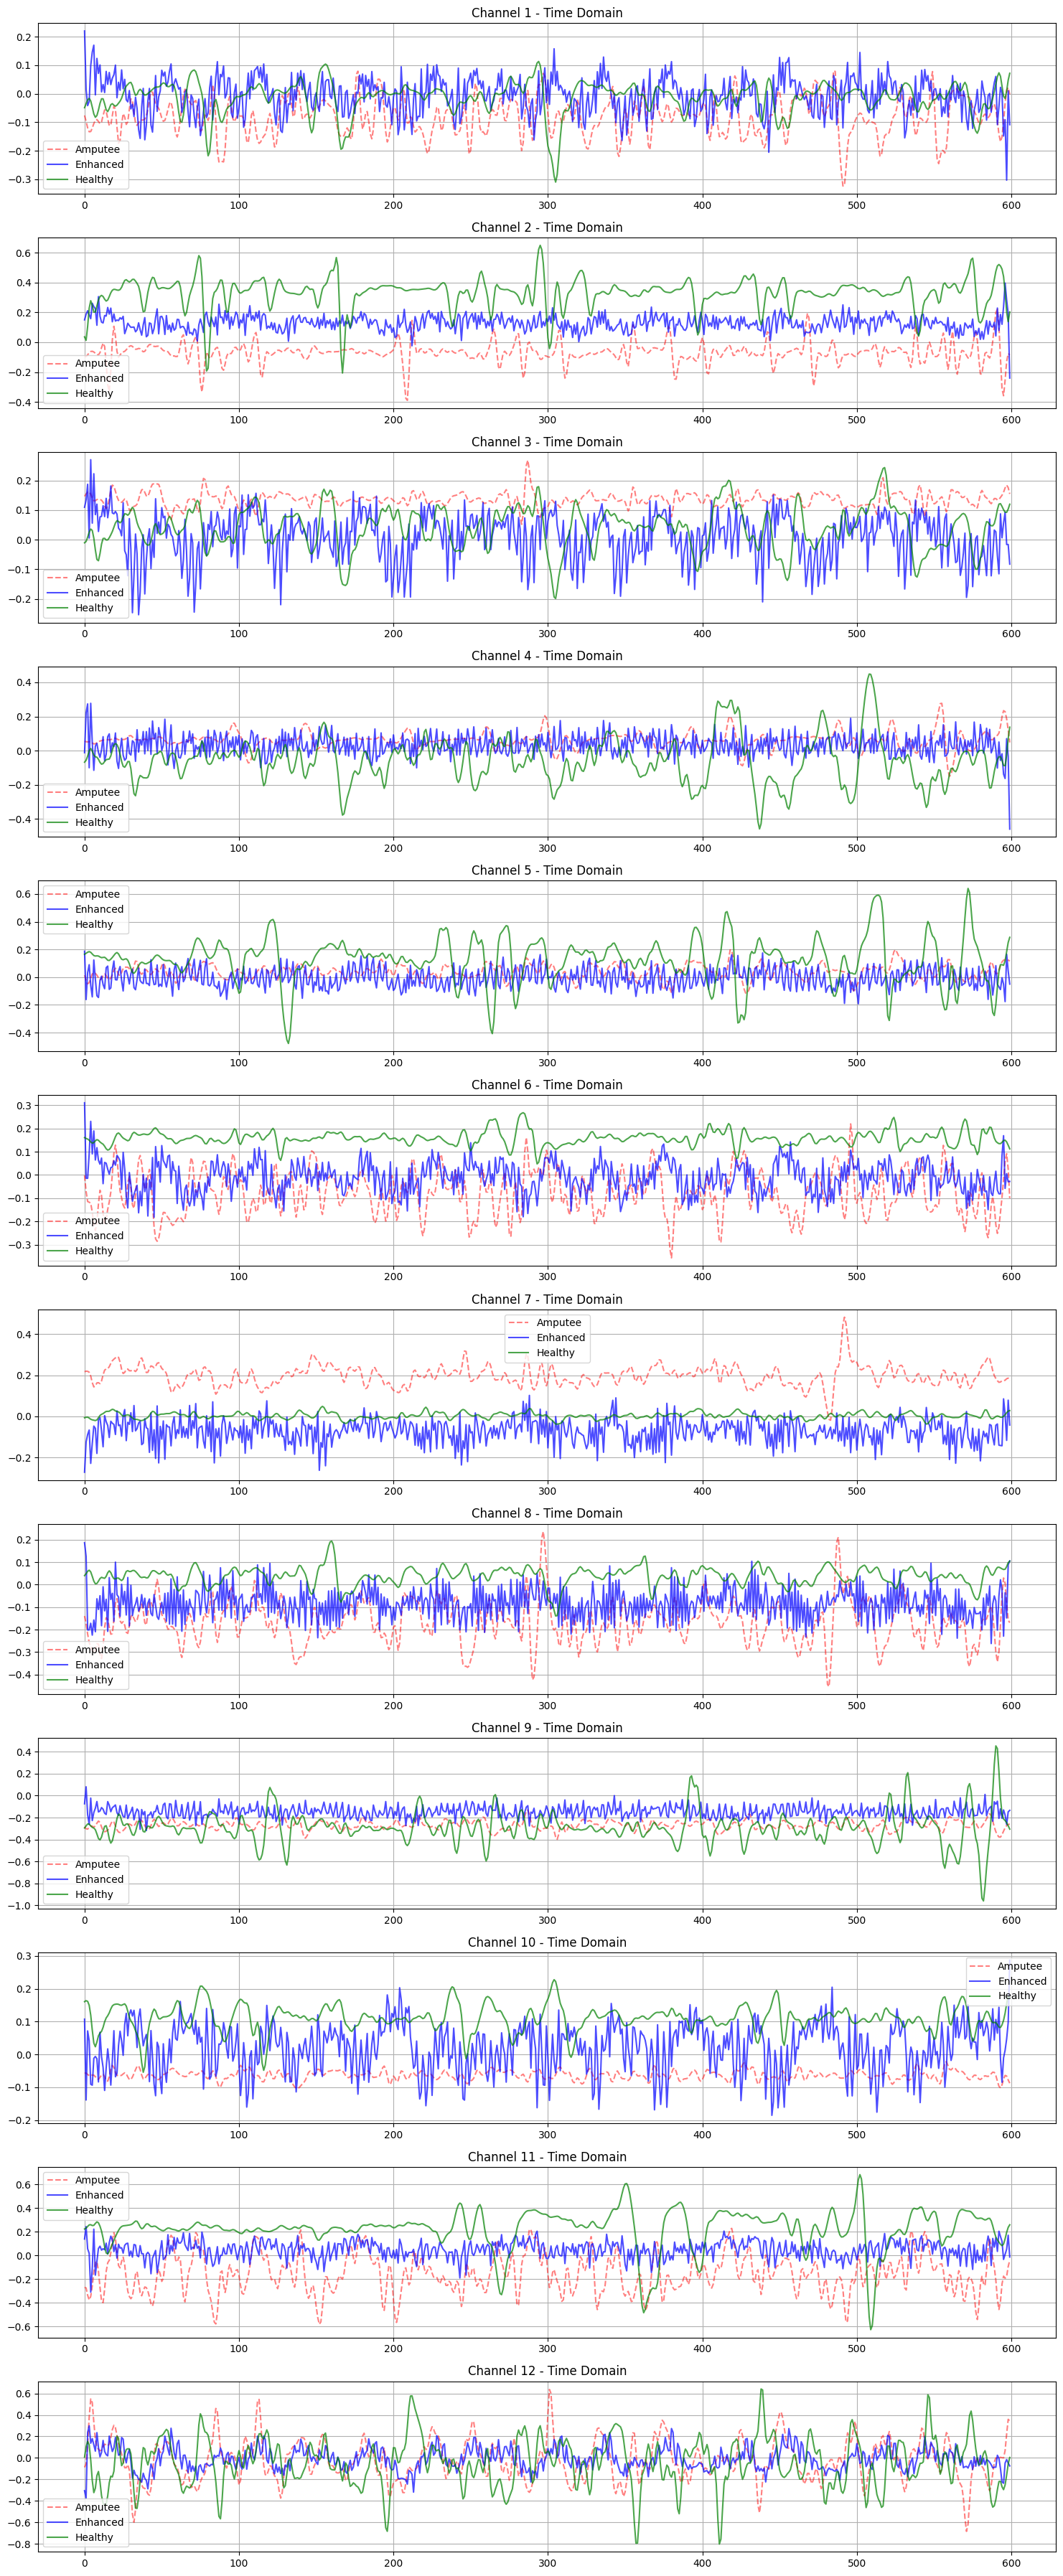

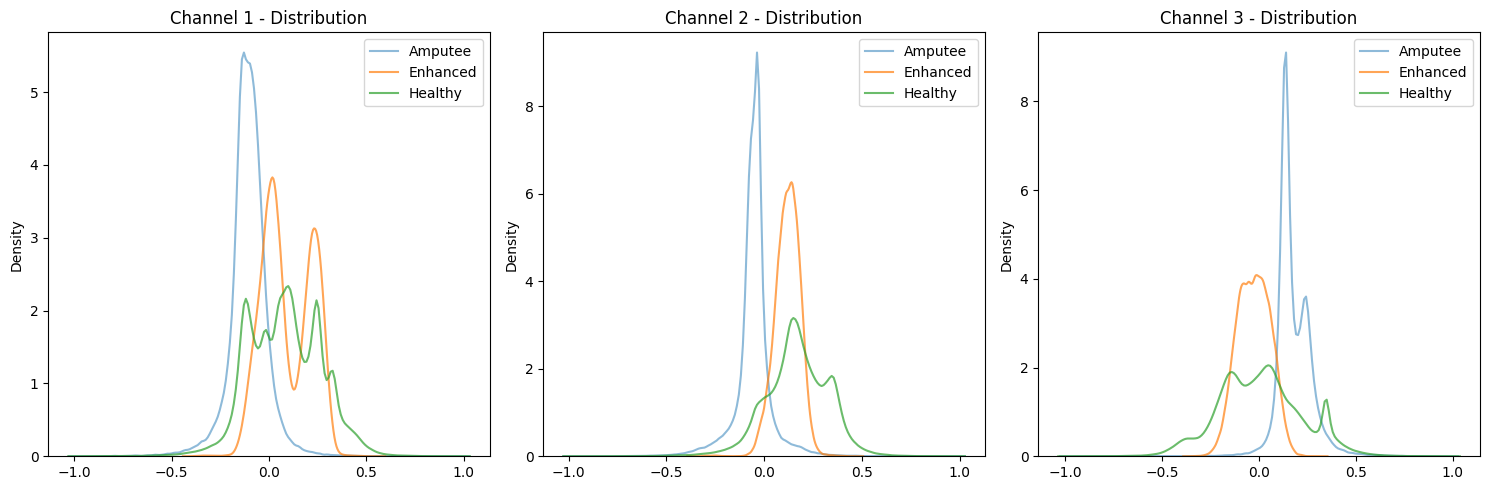

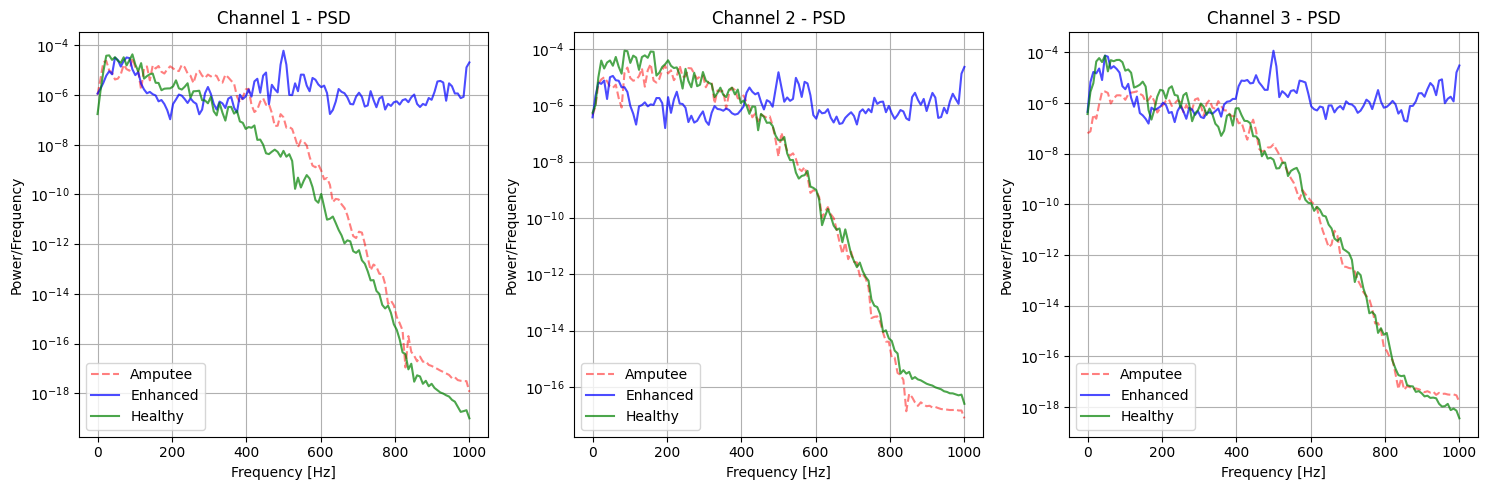


Evaluation Metrics:
--------------------------------------------------

Statistical Metrics:

channel_0:
KS-test statistic: 0.1519
KS-test p-value: 0.0000

Enhanced Signal Stats:
mean: 0.0929
std: 0.1264
skew: 0.1019
kurtosis: -1.0921

Healthy Signal Stats:
mean: 0.0807
std: 0.1830
skew: -0.0053
kurtosis: 0.1943

channel_1:
KS-test statistic: 0.3223
KS-test p-value: 0.0000

Enhanced Signal Stats:
mean: 0.1196
std: 0.0648
skew: -0.4579
kurtosis: 1.9449

Healthy Signal Stats:
mean: 0.1687
std: 0.1610
skew: -0.3474
kurtosis: 1.3446

channel_2:
KS-test statistic: 0.2479
KS-test p-value: 0.0000

Enhanced Signal Stats:
mean: -0.0270
std: 0.0845
skew: -0.0326
kurtosis: -0.4871

Healthy Signal Stats:
mean: 0.0084
std: 0.2141
skew: 0.1345
kurtosis: 0.0289

channel_3:
KS-test statistic: 0.2326
KS-test p-value: 0.0000

Enhanced Signal Stats:
mean: -0.0085
std: 0.0861
skew: -0.5094
kurtosis: 1.6521

Healthy Signal Stats:
mean: -0.0474
std: 0.1880
skew: -0.0561
kurtosis: 0.5168

channel_4:
KS-test

In [ ]:
X_healthy = X_train
X_amputee = X_test

# Initialize CycleGAN
signal_shape = (600, 12)  # window_size=600, n_channels=12
cyclegan = EMGCycleGAN(signal_shape)

# Train the model
history = cyclegan.train(X_amputee, X_healthy, epochs=200, batch_size=32)

# Generate enhanced signals
enhanced_signals = cyclegan.enhance_signals(X_amputee)

# Evaluate results
evaluator = EMGSignalEvaluator()
metrics = evaluator.evaluate(
    enhanced_signals,
    X_healthy,
    X_amputee
)

# Print evaluation metrics
print("\nEvaluation Metrics:")
print("-" * 50)

# Statistical metrics
print("\nStatistical Metrics:")
for ch in metrics['stats']:
    print(f"\n{ch}:")
    print(f"KS-test statistic: {metrics['stats'][ch]['ks_test'].statistic:.4f}")
    print(f"KS-test p-value: {metrics['stats'][ch]['ks_test'].pvalue:.4f}")

    print("\nEnhanced Signal Stats:")
    for stat, value in metrics['stats'][ch]['enhanced_stats'].items():
        print(f"{stat}: {value:.4f}")

    print("\nHealthy Signal Stats:")
    for stat, value in metrics['stats'][ch]['healthy_stats'].items():
        print(f"{stat}: {value:.4f}")

# Frequency metrics
print("\nFrequency Domain Metrics:")
for ch in metrics['freq']:
    print(f"\n{ch}:")
    print(f"Mean frequency difference: {metrics['freq'][ch]['mean_freq_diff']:.4f}")
    print(f"Enhanced mean frequency: {metrics['freq'][ch]['enhanced_freq']['mean']:.4f}")
    print(f"Healthy mean frequency: {metrics['freq'][ch]['healthy_freq']['mean']:.4f}")


# Updating training per amputee

Loading and preprocessing data...
Found 44 .mat files


  0%|                                                    | 0/44 [00:00<?, ?it/s]


Processing subject 4
EMG data shape: (1798063, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 12996 samples
Created 42 segments
Movement 1, Rep 2: Found 13035 samples
Created 42 segments
Movement 1, Rep 3: Found 13000 samples
Created 42 segments
Movement 1, Rep 4: Found 12777 samples
Created 41 segments
Movement 1, Rep 5: Found 12996 samples
Created 42 segments
Movement 1, Rep 6: Found 13002 samples
Created 42 segments
Total segments for movement 1: 251
Added to healthy data
Movement 2, Rep 1: Found 12989 samples
Created 42 segments
Movement 2, Rep 2: Found 12835 samples
Created 41 segments
Movement 2, Rep 3: Found 12942 samples
Created 42 segments
Movement 2, Rep 4: Found 13006 samples
Created 42 segments
Movement 2, Rep 5: Found 12774 samples
Created 41 segments
Movement 2, Rep 6: Found 13001 samples
Created 42 segments
Total segments for movement 2: 250
Added to healthy data
Movement 3, Rep 1: Found 12539

  2%|█                                           | 1/44 [00:03<02:46,  3.87s/it]

Created 30 segments
Total segments for movement 10: 161
Added to healthy data
Movement 11, Rep 1: Found 11154 samples
Created 36 segments
Movement 11, Rep 2: Found 10907 samples
Created 35 segments
Movement 11, Rep 3: Found 9025 samples
Created 29 segments
Movement 11, Rep 4: Found 12494 samples
Created 40 segments
Movement 11, Rep 5: Found 9249 samples
Created 29 segments
Movement 11, Rep 6: Found 10083 samples
Created 32 segments
Total segments for movement 11: 201
Added to healthy data
Movement 12, Rep 1: Found 7862 samples
Created 25 segments
Movement 12, Rep 2: Found 7500 samples
Created 24 segments
Movement 12, Rep 3: Found 7272 samples
Created 23 segments
Movement 12, Rep 4: Found 7251 samples
Created 23 segments
Movement 12, Rep 5: Found 6021 samples
Created 19 segments
Movement 12, Rep 6: Found 7060 samples
Created 22 segments
Total segments for movement 12: 136
Added to healthy data
Movement 13, Rep 1: Found 7180 samples
Created 22 segments
Movement 13, Rep 2: Found 7060 samp

  5%|██                                          | 2/44 [00:07<02:46,  3.96s/it]

Movement 10, Rep 4: Found 6924 samples
Created 22 segments
Movement 10, Rep 5: Found 7080 samples
Created 22 segments
Movement 10, Rep 6: Found 6845 samples
Created 21 segments
Total segments for movement 10: 135
Added to healthy data
Movement 11, Rep 1: Found 7189 samples
Created 22 segments
Movement 11, Rep 2: Found 7788 samples
Created 24 segments
Movement 11, Rep 3: Found 7234 samples
Created 23 segments
Movement 11, Rep 4: Found 8098 samples
Created 25 segments
Movement 11, Rep 5: Found 7914 samples
Created 25 segments
Movement 11, Rep 6: Found 6734 samples
Created 21 segments
Total segments for movement 11: 140
Added to healthy data
Movement 12, Rep 1: Found 7196 samples
Created 22 segments
Movement 12, Rep 2: Found 6241 samples
Created 19 segments
Movement 12, Rep 3: Found 7105 samples
Created 22 segments
Movement 12, Rep 4: Found 6560 samples
Created 20 segments
Movement 12, Rep 5: Found 6595 samples
Created 20 segments
Movement 12, Rep 6: Found 6920 samples
Created 22 segments

  7%|███                                         | 3/44 [00:13<03:15,  4.77s/it]

Movement 40, Rep 1: Found 9927 samples
Created 32 segments
Movement 40, Rep 2: Found 9789 samples
Created 31 segments
Movement 40, Rep 3: Found 8168 samples
Created 26 segments
Movement 40, Rep 4: Found 8464 samples
Created 27 segments
Movement 40, Rep 5: Found 8183 samples
Created 26 segments
Movement 40, Rep 6: Found 9307 samples
Created 30 segments
Total segments for movement 40: 172
Added to healthy data

Processing subject 16
EMG data shape: (1797280, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 7898 samples
Created 25 segments
Movement 1, Rep 2: Found 8941 samples
Created 28 segments
Movement 1, Rep 3: Found 9125 samples
Created 29 segments
Movement 1, Rep 4: Found 9815 samples
Created 31 segments
Movement 1, Rep 5: Found 9732 samples
Created 31 segments
Movement 1, Rep 6: Found 10161 samples
Created 32 segments
Total segments for movement 1: 176
Added to healthy data
Movement 2, Rep 1: Found 6582 sam

  9%|████                                        | 4/44 [00:17<02:55,  4.40s/it]

Movement 11, Rep 1: Found 7554 samples
Created 24 segments
Movement 11, Rep 2: Found 7408 samples
Created 23 segments
Movement 11, Rep 3: Found 7689 samples
Created 24 segments
Movement 11, Rep 4: Found 7408 samples
Created 23 segments
Movement 11, Rep 5: Found 7218 samples
Created 23 segments
Movement 11, Rep 6: Found 7627 samples
Created 24 segments
Total segments for movement 11: 141
Added to healthy data
Movement 12, Rep 1: Found 7076 samples
Created 22 segments
Movement 12, Rep 2: Found 7204 samples
Created 23 segments
Movement 12, Rep 3: Found 7475 samples
Created 23 segments
Movement 12, Rep 4: Found 6380 samples
Created 20 segments
Movement 12, Rep 5: Found 7169 samples
Created 22 segments
Movement 12, Rep 6: Found 6163 samples
Created 19 segments
Total segments for movement 12: 129
Added to healthy data
Movement 13, Rep 1: Found 7482 samples
Created 23 segments
Movement 13, Rep 2: Found 7383 samples
Created 23 segments
Movement 13, Rep 3: Found 7686 samples
Created 24 segments

 11%|█████                                       | 5/44 [00:23<03:08,  4.82s/it]

Created 21 segments
Movement 40, Rep 3: Found 6529 samples
Created 20 segments
Movement 40, Rep 4: Found 7213 samples
Created 23 segments
Movement 40, Rep 5: Found 6129 samples
Created 19 segments
Movement 40, Rep 6: Found 7029 samples
Created 22 segments
Total segments for movement 40: 133
Added to healthy data

Processing subject 19
EMG data shape: (2530177, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 7049 samples
Created 22 segments
Movement 18, Rep 2: Found 6944 samples
Created 22 segments
Movement 18, Rep 3: Found 6098 samples
Created 19 segments
Movement 18, Rep 4: Found 6794 samples
Created 21 segments
Movement 18, Rep 5: Found 6299 samples
Created 19 segments
Movement 18, Rep 6: Found 6318 samples
Created 20 segments
Total segments for movement 18: 123
Added to healthy data
Movement 19, Rep 1: Found 7106 samples
Created 22 segments
Movement 19, Rep 2: Found 6120 samples
Created 1

 14%|██████                                      | 6/44 [00:28<03:12,  5.07s/it]

Created 26 segments
Movement 40, Rep 2: Found 7569 samples
Created 24 segments
Movement 40, Rep 3: Found 9509 samples
Created 30 segments
Movement 40, Rep 4: Found 9549 samples
Created 30 segments
Movement 40, Rep 5: Found 8959 samples
Created 28 segments
Movement 40, Rep 6: Found 8330 samples
Created 26 segments
Total segments for movement 40: 164
Added to healthy data

Processing subject 2
EMG data shape: (1795164, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 11127 samples
Created 36 segments
Movement 1, Rep 2: Found 11145 samples
Created 36 segments
Movement 1, Rep 3: Found 12241 samples
Created 39 segments
Movement 1, Rep 4: Found 10571 samples
Created 34 segments
Movement 1, Rep 5: Found 9597 samples
Created 30 segments
Movement 1, Rep 6: Found 8476 samples
Created 27 segments
Total segments for movement 1: 202
Added to healthy data
Movement 2, Rep 1: Found 12912 samples
Created 42 segments
Movement 2,

 16%|███████                                     | 7/44 [00:32<02:52,  4.67s/it]

Created 29 segments
Movement 11, Rep 3: Found 9138 samples
Created 29 segments
Movement 11, Rep 4: Found 8658 samples
Created 27 segments
Movement 11, Rep 5: Found 9139 samples
Created 29 segments
Movement 11, Rep 6: Found 7995 samples
Created 25 segments
Total segments for movement 11: 165
Added to healthy data
Movement 12, Rep 1: Found 7080 samples
Created 22 segments
Movement 12, Rep 2: Found 7321 samples
Created 23 segments
Movement 12, Rep 3: Found 6613 samples
Created 21 segments
Movement 12, Rep 4: Found 4416 samples
Created 13 segments
Movement 12, Rep 5: Found 4820 samples
Created 15 segments
Movement 12, Rep 6: Found 6116 samples
Created 19 segments
Total segments for movement 12: 113
Added to healthy data
Movement 13, Rep 1: Found 6320 samples
Created 20 segments
Movement 13, Rep 2: Found 5241 samples
Created 16 segments
Movement 13, Rep 3: Found 4975 samples
Created 15 segments
Movement 13, Rep 4: Found 4909 samples
Created 15 segments
Movement 13, Rep 5: Found 4984 samples

 18%|████████                                    | 8/44 [00:36<02:37,  4.38s/it]

Movement 11, Rep 2: Found 7844 samples
Created 25 segments
Movement 11, Rep 3: Found 7687 samples
Created 24 segments
Movement 11, Rep 4: Found 7794 samples
Created 24 segments
Movement 11, Rep 5: Found 8228 samples
Created 26 segments
Movement 11, Rep 6: Found 9429 samples
Created 30 segments
Total segments for movement 11: 153
Added to healthy data
Movement 12, Rep 1: Found 7200 samples
Created 23 segments
Movement 12, Rep 2: Found 8005 samples
Created 25 segments
Movement 12, Rep 3: Found 7931 samples
Created 25 segments
Movement 12, Rep 4: Found 6861 samples
Created 21 segments
Movement 12, Rep 5: Found 7080 samples
Created 22 segments
Movement 12, Rep 6: Found 7145 samples
Created 22 segments
Total segments for movement 12: 138
Added to healthy data
Movement 13, Rep 1: Found 8250 samples
Created 26 segments
Movement 13, Rep 2: Found 8254 samples
Created 26 segments
Movement 13, Rep 3: Found 8382 samples
Created 26 segments
Movement 13, Rep 4: Found 8642 samples
Created 27 segments

 20%|█████████                                   | 9/44 [00:41<02:46,  4.75s/it]

Movement 38, Rep 3: Found 7453 samples
Created 23 segments
Movement 38, Rep 4: Found 8130 samples
Created 26 segments
Movement 38, Rep 5: Found 8718 samples
Created 28 segments
Movement 38, Rep 6: Found 8548 samples
Created 27 segments
Total segments for movement 38: 155
Added to amputee data

Processing subject 14
EMG data shape: (2532247, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 6889 samples
Created 21 segments
Movement 18, Rep 2: Found 7309 samples
Created 23 segments
Movement 18, Rep 3: Found 7390 samples
Created 23 segments
Movement 18, Rep 4: Found 7025 samples
Created 22 segments
Movement 18, Rep 5: Found 8269 samples
Created 26 segments
Movement 18, Rep 6: Found 9764 samples
Created 31 segments
Total segments for movement 18: 146
Added to healthy data
Movement 19, Rep 1: Found 7513 samples
Created 24 segments
Movement 19, Rep 2: Found 8263 samples
Created 26 segments
Movement 

 23%|█████████▊                                 | 10/44 [00:47<02:49,  4.99s/it]

Movement 39, Rep 6: Found 7409 samples
Created 23 segments
Total segments for movement 39: 136
Added to healthy data
Movement 40, Rep 1: Found 9829 samples
Created 31 segments
Movement 40, Rep 2: Found 7949 samples
Created 25 segments
Movement 40, Rep 3: Found 8984 samples
Created 28 segments
Movement 40, Rep 4: Found 7584 samples
Created 24 segments
Movement 40, Rep 5: Found 9249 samples
Created 29 segments
Movement 40, Rep 6: Found 8617 samples
Created 27 segments
Total segments for movement 40: 164
Added to healthy data

Processing subject 5
EMG data shape: (1797365, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 6547 samples
Created 20 segments
Movement 1, Rep 2: Found 6706 samples
Created 21 segments
Movement 1, Rep 3: Found 6896 samples
Created 21 segments
Movement 1, Rep 4: Found 6926 samples
Created 22 segments
Movement 1, Rep 5: Found 8511 samples
Created 27 segments
Movement 1, Rep 6: Found 7401 sam

 25%|██████████▊                                | 11/44 [00:51<02:32,  4.61s/it]

Movement 11, Rep 4: Found 5909 samples
Created 18 segments
Movement 11, Rep 5: Found 6973 samples
Created 22 segments
Movement 11, Rep 6: Found 6769 samples
Created 21 segments
Total segments for movement 11: 113
Added to healthy data
Movement 12, Rep 1: Found 5868 samples
Created 18 segments
Movement 12, Rep 2: Found 5333 samples
Created 16 segments
Movement 12, Rep 3: Found 5322 samples
Created 16 segments
Movement 12, Rep 4: Found 7001 samples
Created 22 segments
Movement 12, Rep 5: Found 5621 samples
Created 17 segments
Movement 12, Rep 6: Found 4705 samples
Created 14 segments
Total segments for movement 12: 103
Added to healthy data
Movement 13, Rep 1: Found 7066 samples
Created 22 segments
Movement 13, Rep 2: Found 5900 samples
Created 18 segments
Movement 13, Rep 3: Found 6495 samples
Created 20 segments
Movement 13, Rep 4: Found 6272 samples
Created 19 segments
Movement 13, Rep 5: Found 6495 samples
Created 20 segments
Movement 13, Rep 6: Found 5866 samples
Created 18 segments

 27%|███████████▋                               | 12/44 [00:56<02:36,  4.88s/it]

Created 31 segments
Movement 40, Rep 2: Found 8708 samples
Created 28 segments
Movement 40, Rep 3: Found 8874 samples
Created 28 segments
Movement 40, Rep 4: Found 9544 samples
Created 30 segments
Movement 40, Rep 5: Found 8700 samples
Created 28 segments
Movement 40, Rep 6: Found 9213 samples
Created 29 segments
Total segments for movement 40: 174
Added to healthy data

Processing subject 8
EMG data shape: (1795724, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 11459 samples
Created 37 segments
Movement 1, Rep 2: Found 11889 samples
Created 38 segments
Movement 1, Rep 3: Found 12831 samples
Created 41 segments
Movement 1, Rep 4: Found 12666 samples
Created 41 segments
Movement 1, Rep 5: Found 12880 samples
Created 41 segments
Movement 1, Rep 6: Found 12646 samples
Created 41 segments
Total segments for movement 1: 239
Added to healthy data
Movement 2, Rep 1: Found 7352 samples
Created 23 segments
Movement 2

 30%|████████████▋                              | 13/44 [01:00<02:20,  4.54s/it]

Created 24 segments
Movement 11, Rep 2: Found 7540 samples
Created 24 segments
Movement 11, Rep 3: Found 7346 samples
Created 23 segments
Movement 11, Rep 4: Found 7899 samples
Created 25 segments
Movement 11, Rep 5: Found 7869 samples
Created 25 segments
Movement 11, Rep 6: Found 9079 samples
Created 29 segments
Total segments for movement 11: 150
Added to healthy data
Movement 12, Rep 1: Found 7421 samples
Created 23 segments
Movement 12, Rep 2: Found 7521 samples
Created 24 segments
Movement 12, Rep 3: Found 7064 samples
Created 22 segments
Movement 12, Rep 4: Found 7220 samples
Created 23 segments
Movement 12, Rep 5: Found 7640 samples
Created 24 segments
Movement 12, Rep 6: Found 7061 samples
Created 22 segments
Total segments for movement 12: 138
Added to healthy data
Movement 13, Rep 1: Found 7291 samples
Created 23 segments
Movement 13, Rep 2: Found 7713 samples
Created 24 segments
Movement 13, Rep 3: Found 8065 samples
Created 25 segments
Movement 13, Rep 4: Found 7577 samples

 32%|█████████████▋                             | 14/44 [01:05<02:24,  4.81s/it]

Movement 40, Rep 1: Found 10048 samples
Created 32 segments
Movement 40, Rep 2: Found 10789 samples
Created 34 segments
Movement 40, Rep 3: Found 8350 samples
Created 26 segments
Movement 40, Rep 4: Found 7999 samples
Created 25 segments
Movement 40, Rep 5: Found 8468 samples
Created 27 segments
Movement 40, Rep 6: Found 8789 samples
Created 28 segments
Total segments for movement 40: 172
Added to healthy data

Processing subject 22
EMG data shape: (2053988, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 4837 samples
Created 15 segments
Movement 1, Rep 2: Found 7006 samples
Created 22 segments
Movement 1, Rep 3: Found 4678 samples
Created 14 segments
Movement 1, Rep 4: Found 4513 samples
Created 14 segments
Movement 1, Rep 5: Found 5495 samples
Created 17 segments
Movement 1, Rep 6: Found 8727 samples
Created 28 segments
Total segments for movement 1: 110
Added to amputee data
Movement 2, Rep 1: Found 6682 sa

 34%|██████████████▋                            | 15/44 [01:09<02:12,  4.58s/it]

Created 14 segments
Movement 10, Rep 3: Found 5130 samples
Created 16 segments
Movement 10, Rep 4: Found 4457 samples
Created 13 segments
Movement 10, Rep 5: Found 4441 samples
Created 13 segments
Movement 10, Rep 6: Found 4572 samples
Created 14 segments
Total segments for movement 10: 83
Added to amputee data
Movement 11, Rep 1: Found 6454 samples
Created 20 segments
Movement 11, Rep 2: Found 6256 samples
Created 19 segments
Movement 11, Rep 3: Found 6190 samples
Created 19 segments
Movement 11, Rep 4: Found 6282 samples
Created 19 segments
Movement 11, Rep 5: Found 6098 samples
Created 19 segments
Movement 11, Rep 6: Found 6648 samples
Created 21 segments
Total segments for movement 11: 117
Added to amputee data
Movement 12, Rep 1: Found 5014 samples
Created 15 segments
Movement 12, Rep 2: Found 5830 samples
Created 18 segments
Movement 12, Rep 3: Found 5022 samples
Created 15 segments
Movement 12, Rep 4: Found 5062 samples
Created 15 segments
Movement 12, Rep 5: Found 4812 samples


 36%|███████████████▋                           | 16/44 [01:13<02:01,  4.35s/it]

Created 22 segments
Movement 11, Rep 2: Found 7250 samples
Created 23 segments
Movement 11, Rep 3: Found 7190 samples
Created 22 segments
Movement 11, Rep 4: Found 7167 samples
Created 22 segments
Movement 11, Rep 5: Found 7458 samples
Created 23 segments
Movement 11, Rep 6: Found 6490 samples
Created 20 segments
Total segments for movement 11: 132
Added to healthy data
Movement 12, Rep 1: Found 7623 samples
Created 24 segments
Movement 12, Rep 2: Found 7863 samples
Created 25 segments
Movement 12, Rep 3: Found 7678 samples
Created 24 segments
Movement 12, Rep 4: Found 7638 samples
Created 24 segments
Movement 12, Rep 5: Found 7221 samples
Created 23 segments
Movement 12, Rep 6: Found 7287 samples
Created 23 segments
Total segments for movement 12: 143
Added to healthy data
Movement 13, Rep 1: Found 8018 samples
Created 25 segments
Movement 13, Rep 2: Found 8041 samples
Created 25 segments
Movement 13, Rep 3: Found 6921 samples
Created 22 segments
Movement 13, Rep 4: Found 6643 samples

 39%|████████████████▌                          | 17/44 [01:19<02:07,  4.73s/it]

Created 29 segments
Movement 39, Rep 5: Found 6958 samples
Created 22 segments
Movement 39, Rep 6: Found 8289 samples
Created 26 segments
Total segments for movement 39: 151
Added to healthy data
Movement 40, Rep 1: Found 9139 samples
Created 29 segments
Movement 40, Rep 2: Found 10429 samples
Created 33 segments
Movement 40, Rep 3: Found 8789 samples
Created 28 segments
Movement 40, Rep 4: Found 8840 samples
Created 28 segments
Movement 40, Rep 5: Found 8394 samples
Created 26 segments
Movement 40, Rep 6: Found 9329 samples
Created 30 segments
Total segments for movement 40: 174
Added to healthy data

Processing subject 18
EMG data shape: (2533999, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 7676 samples
Created 24 segments
Movement 18, Rep 2: Found 8189 samples
Created 26 segments
Movement 18, Rep 3: Found 7790 samples
Created 24 segments
Movement 18, Rep 4: Found 7549 samples
Created 

 41%|█████████████████▌                         | 18/44 [01:24<02:09,  4.97s/it]

Movement 39, Rep 3: Found 8489 samples
Created 27 segments
Movement 39, Rep 4: Found 8289 samples
Created 26 segments
Movement 39, Rep 5: Found 6177 samples
Created 19 segments
Movement 39, Rep 6: Found 7250 samples
Created 23 segments
Total segments for movement 39: 142
Added to healthy data
Movement 40, Rep 1: Found 5991 samples
Created 18 segments
Movement 40, Rep 2: Found 5559 samples
Created 17 segments
Movement 40, Rep 3: Found 8767 samples
Created 28 segments
Movement 40, Rep 4: Found 9268 samples
Created 29 segments
Movement 40, Rep 5: Found 8547 samples
Created 27 segments
Movement 40, Rep 6: Found 8551 samples
Created 27 segments
Total segments for movement 40: 146
Added to healthy data

Processing subject 3
EMG data shape: (1804054, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 10208 samples
Created 33 segments
Movement 1, Rep 2: Found 7519 samples
Created 24 segments
Movement 1, Rep 3: Found 8162

 43%|██████████████████▌                        | 19/44 [01:28<01:55,  4.64s/it]

Created 19 segments
Movement 11, Rep 2: Found 5969 samples
Created 18 segments
Movement 11, Rep 3: Found 6609 samples
Created 21 segments
Movement 11, Rep 4: Found 6297 samples
Created 19 segments
Movement 11, Rep 5: Found 6028 samples
Created 19 segments
Movement 11, Rep 6: Found 6584 samples
Created 20 segments
Total segments for movement 11: 116
Added to healthy data
Movement 12, Rep 1: Found 5282 samples
Created 16 segments
Movement 12, Rep 2: Found 7016 samples
Created 22 segments
Movement 12, Rep 3: Found 6176 samples
Created 19 segments
Movement 12, Rep 4: Found 6893 samples
Created 21 segments
Movement 12, Rep 5: Found 6013 samples
Created 19 segments
Movement 12, Rep 6: Found 6014 samples
Created 19 segments
Total segments for movement 12: 116
Added to healthy data
Movement 13, Rep 1: Found 7422 samples
Created 23 segments
Movement 13, Rep 2: Found 5501 samples
Created 17 segments
Movement 13, Rep 3: Found 7026 samples
Created 22 segments
Movement 13, Rep 4: Found 5262 samples

 45%|███████████████████▌                       | 20/44 [01:34<01:58,  4.92s/it]

Movement 39, Rep 3: Found 7270 samples
Created 23 segments
Movement 39, Rep 4: Found 8780 samples
Created 28 segments
Movement 39, Rep 5: Found 8605 samples
Created 27 segments
Movement 39, Rep 6: Found 7561 samples
Created 24 segments
Total segments for movement 39: 148
Added to healthy data
Movement 40, Rep 1: Found 8469 samples
Created 27 segments
Movement 40, Rep 2: Found 8847 samples
Created 28 segments
Movement 40, Rep 3: Found 8804 samples
Created 28 segments
Movement 40, Rep 4: Found 8914 samples
Created 28 segments
Movement 40, Rep 5: Found 8509 samples
Created 27 segments
Movement 40, Rep 6: Found 8943 samples
Created 28 segments
Total segments for movement 40: 166
Added to healthy data

Processing subject 11
EMG data shape: (1797940, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 10452 samples
Created 33 segments
Movement 1, Rep 2: Found 10165 samples
Created 32 segments
Movement 1, Rep 3: Found 86

 48%|████████████████████▌                      | 21/44 [01:37<01:45,  4.58s/it]

Created 29 segments
Movement 11, Rep 2: Found 7963 samples
Created 25 segments
Movement 11, Rep 3: Found 6573 samples
Created 20 segments
Movement 11, Rep 4: Found 8290 samples
Created 26 segments
Movement 11, Rep 5: Found 7580 samples
Created 24 segments
Movement 11, Rep 6: Found 9015 samples
Created 29 segments
Total segments for movement 11: 153
Added to healthy data
Movement 12, Rep 1: Found 8150 samples
Created 26 segments
Movement 12, Rep 2: Found 8038 samples
Created 25 segments
Movement 12, Rep 3: Found 7450 samples
Created 23 segments
Movement 12, Rep 4: Found 7650 samples
Created 24 segments
Movement 12, Rep 5: Found 7844 samples
Created 25 segments
Movement 12, Rep 6: Found 7131 samples
Created 22 segments
Total segments for movement 12: 145
Added to healthy data
Movement 13, Rep 1: Found 6637 samples
Created 21 segments
Movement 13, Rep 2: Found 5501 samples
Created 17 segments
Movement 13, Rep 3: Found 7781 samples
Created 24 segments
Movement 13, Rep 4: Found 4492 samples

 50%|█████████████████████▌                     | 22/44 [01:43<01:46,  4.84s/it]

Movement 40, Rep 1: Found 8338 samples
Created 26 segments
Movement 40, Rep 2: Found 8589 samples
Created 27 segments
Movement 40, Rep 3: Found 8269 samples
Created 26 segments
Movement 40, Rep 4: Found 6944 samples
Created 22 segments
Movement 40, Rep 5: Found 7374 samples
Created 23 segments
Movement 40, Rep 6: Found 8449 samples
Created 27 segments
Total segments for movement 40: 151
Added to healthy data

Processing subject 2
EMG data shape: (2530807, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 10112 samples
Created 32 segments
Movement 18, Rep 2: Found 12598 samples
Created 40 segments
Movement 18, Rep 3: Found 11229 samples
Created 36 segments
Movement 18, Rep 4: Found 8449 samples
Created 27 segments
Movement 18, Rep 5: Found 11809 samples
Created 38 segments
Movement 18, Rep 6: Found 7668 samples
Created 24 segments
Total segments for movement 18: 197
Added to healthy data
Moveme

 52%|██████████████████████▍                    | 23/44 [01:48<01:46,  5.06s/it]

Movement 39, Rep 1: Found 7189 samples
Created 22 segments
Movement 39, Rep 2: Found 8158 samples
Created 26 segments
Movement 39, Rep 3: Found 7009 samples
Created 22 segments
Movement 39, Rep 4: Found 7788 samples
Created 24 segments
Movement 39, Rep 5: Found 7689 samples
Created 24 segments
Movement 39, Rep 6: Found 7073 samples
Created 22 segments
Total segments for movement 39: 140
Added to healthy data
Movement 40, Rep 1: Found 9609 samples
Created 31 segments
Movement 40, Rep 2: Found 9369 samples
Created 30 segments
Movement 40, Rep 3: Found 9209 samples
Created 29 segments
Movement 40, Rep 4: Found 9065 samples
Created 29 segments
Movement 40, Rep 5: Found 8072 samples
Created 25 segments
Movement 40, Rep 6: Found 8039 samples
Created 25 segments
Total segments for movement 40: 169
Added to healthy data

Processing subject 19
EMG data shape: (1796662, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 94

 55%|███████████████████████▍                   | 24/44 [01:52<01:34,  4.70s/it]

Created 19 segments
Movement 11, Rep 2: Found 6304 samples
Created 20 segments
Movement 11, Rep 3: Found 7119 samples
Created 22 segments
Movement 11, Rep 4: Found 6949 samples
Created 22 segments
Movement 11, Rep 5: Found 7643 samples
Created 24 segments
Movement 11, Rep 6: Found 9400 samples
Created 30 segments
Total segments for movement 11: 137
Added to healthy data
Movement 12, Rep 1: Found 6151 samples
Created 19 segments
Movement 12, Rep 2: Found 6891 samples
Created 21 segments
Movement 12, Rep 3: Found 6646 samples
Created 21 segments
Movement 12, Rep 4: Found 6085 samples
Created 19 segments
Movement 12, Rep 5: Found 7261 samples
Created 23 segments
Movement 12, Rep 6: Found 8670 samples
Created 27 segments
Total segments for movement 12: 130
Added to healthy data
Movement 13, Rep 1: Found 5730 samples
Created 18 segments
Movement 13, Rep 2: Found 5796 samples
Created 18 segments
Movement 13, Rep 3: Found 7575 samples
Created 24 segments
Movement 13, Rep 4: Found 6297 samples

 57%|████████████████████████▍                  | 25/44 [01:56<01:24,  4.45s/it]

Movement 11, Rep 3: Found 7549 samples
Created 24 segments
Movement 11, Rep 4: Found 8009 samples
Created 25 segments
Movement 11, Rep 5: Found 7598 samples
Created 24 segments
Movement 11, Rep 6: Found 7625 samples
Created 24 segments
Total segments for movement 11: 143
Added to healthy data
Movement 12, Rep 1: Found 7268 samples
Created 23 segments
Movement 12, Rep 2: Found 7680 samples
Created 24 segments
Movement 12, Rep 3: Found 7372 samples
Created 23 segments
Movement 12, Rep 4: Found 7329 samples
Created 23 segments
Movement 12, Rep 5: Found 7766 samples
Created 24 segments
Movement 12, Rep 6: Found 7408 samples
Created 23 segments
Total segments for movement 12: 140
Added to healthy data
Movement 13, Rep 1: Found 7562 samples
Created 24 segments
Movement 13, Rep 2: Found 8060 samples
Created 25 segments
Movement 13, Rep 3: Found 7744 samples
Created 24 segments
Movement 13, Rep 4: Found 8175 samples
Created 26 segments
Movement 13, Rep 5: Found 8157 samples
Created 26 segments

 59%|█████████████████████████▍                 | 26/44 [02:00<01:16,  4.28s/it]

Movement 11, Rep 1: Found 6763 samples
Created 21 segments
Movement 11, Rep 2: Found 6985 samples
Created 22 segments
Movement 11, Rep 3: Found 8087 samples
Created 25 segments
Movement 11, Rep 4: Found 7213 samples
Created 23 segments
Movement 11, Rep 5: Found 7837 samples
Created 25 segments
Movement 11, Rep 6: Found 7940 samples
Created 25 segments
Total segments for movement 11: 141
Added to healthy data
Movement 12, Rep 1: Found 6326 samples
Created 20 segments
Movement 12, Rep 2: Found 7180 samples
Created 22 segments
Movement 12, Rep 3: Found 7411 samples
Created 23 segments
Movement 12, Rep 4: Found 6947 samples
Created 22 segments
Movement 12, Rep 5: Found 5661 samples
Created 17 segments
Movement 12, Rep 6: Found 7399 samples
Created 23 segments
Total segments for movement 12: 127
Added to healthy data
Movement 13, Rep 1: Found 7336 samples
Created 23 segments
Movement 13, Rep 2: Found 7064 samples
Created 22 segments
Movement 13, Rep 3: Found 8001 samples
Created 25 segments

 61%|██████████████████████████▍                | 27/44 [02:04<01:12,  4.29s/it]

Movement 9, Rep 5: Found 9753 samples
Created 31 segments
Movement 9, Rep 6: Found 10603 samples
Created 34 segments
Total segments for movement 9: 235
Added to amputee data
Movement 10, Rep 1: Found 4490 samples
Created 13 segments
Movement 10, Rep 2: Found 4495 samples
Created 13 segments
Movement 10, Rep 3: Found 4460 samples
Created 13 segments
Movement 10, Rep 4: Found 4734 samples
Created 14 segments
Movement 10, Rep 5: Found 4610 samples
Created 14 segments
Movement 10, Rep 6: Found 4489 samples
Created 13 segments
Total segments for movement 10: 80
Added to amputee data
Movement 11, Rep 1: Found 10855 samples
Created 35 segments
Movement 11, Rep 2: Found 11635 samples
Created 37 segments
Movement 11, Rep 3: Found 8865 samples
Created 28 segments
Movement 11, Rep 4: Found 10906 samples
Created 35 segments
Movement 11, Rep 5: Found 10589 samples
Created 34 segments
Movement 11, Rep 6: Found 15510 samples
Created 50 segments
Total segments for movement 11: 219
Added to amputee dat

 64%|███████████████████████████▎               | 28/44 [02:10<01:14,  4.65s/it]

Movement 39, Rep 6: Found 8863 samples
Created 28 segments
Total segments for movement 39: 153
Added to healthy data
Movement 40, Rep 1: Found 10815 samples
Created 35 segments
Movement 40, Rep 2: Found 9567 samples
Created 30 segments
Movement 40, Rep 3: Found 9389 samples
Created 30 segments
Movement 40, Rep 4: Found 10307 samples
Created 33 segments
Movement 40, Rep 5: Found 10042 samples
Created 32 segments
Movement 40, Rep 6: Found 9517 samples
Created 30 segments
Total segments for movement 40: 190
Added to healthy data

Processing subject 4
EMG data shape: (2531248, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 10519 samples
Created 34 segments
Movement 18, Rep 2: Found 12578 samples
Created 40 segments
Movement 18, Rep 3: Found 8697 samples
Created 27 segments
Movement 18, Rep 4: Found 8609 samples
Created 27 segments
Movement 18, Rep 5: Found 7978 samples
Created 25 segments
Movem

 66%|████████████████████████████▎              | 29/44 [02:16<01:14,  4.96s/it]

Created 27 segments
Movement 38, Rep 6: Found 6197 samples
Created 19 segments
Total segments for movement 38: 162
Added to healthy data
Movement 39, Rep 1: Found 8504 samples
Created 27 segments
Movement 39, Rep 2: Found 6698 samples
Created 21 segments
Movement 39, Rep 3: Found 7688 samples
Created 24 segments
Movement 39, Rep 4: Found 8407 samples
Created 27 segments
Movement 39, Rep 5: Found 7904 samples
Created 25 segments
Movement 39, Rep 6: Found 8399 samples
Created 26 segments
Total segments for movement 39: 150
Added to healthy data
Movement 40, Rep 1: Found 8229 samples
Created 26 segments
Movement 40, Rep 2: Found 8069 samples
Created 25 segments
Movement 40, Rep 3: Found 8009 samples
Created 25 segments
Movement 40, Rep 4: Found 8849 samples
Created 28 segments
Movement 40, Rep 5: Found 8219 samples
Created 26 segments
Movement 40, Rep 6: Found 7840 samples
Created 25 segments
Total segments for movement 40: 155
Added to healthy data

Processing subject 16
EMG data shape: 

 68%|█████████████████████████████▎             | 30/44 [02:21<01:11,  5.13s/it]

Created 28 segments
Movement 40, Rep 2: Found 7047 samples
Created 22 segments
Movement 40, Rep 3: Found 6829 samples
Created 21 segments
Movement 40, Rep 4: Found 6682 samples
Created 21 segments
Movement 40, Rep 5: Found 6579 samples
Created 20 segments
Movement 40, Rep 6: Found 7360 samples
Created 23 segments
Total segments for movement 40: 135
Added to healthy data

Processing subject 12
EMG data shape: (1795163, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 10499 samples
Created 33 segments
Movement 1, Rep 2: Found 9995 samples
Created 32 segments
Movement 1, Rep 3: Found 9894 samples
Created 31 segments
Movement 1, Rep 4: Found 11542 samples
Created 37 segments
Movement 1, Rep 5: Found 11266 samples
Created 36 segments
Movement 1, Rep 6: Found 11575 samples
Created 37 segments
Total segments for movement 1: 206
Added to healthy data
Movement 2, Rep 1: Found 8580 samples
Created 27 segments
Movement 2,

 70%|██████████████████████████████▎            | 31/44 [02:25<01:01,  4.72s/it]

Movement 11, Rep 3: Found 9029 samples
Created 29 segments
Movement 11, Rep 4: Found 7884 samples
Created 25 segments
Movement 11, Rep 5: Found 8194 samples
Created 26 segments
Movement 11, Rep 6: Found 8520 samples
Created 27 segments
Total segments for movement 11: 158
Added to healthy data
Movement 12, Rep 1: Found 7622 samples
Created 24 segments
Movement 12, Rep 2: Found 7289 samples
Created 23 segments
Movement 12, Rep 3: Found 7630 samples
Created 24 segments
Movement 12, Rep 4: Found 7525 samples
Created 24 segments
Movement 12, Rep 5: Found 6931 samples
Created 22 segments
Movement 12, Rep 6: Found 7048 samples
Created 22 segments
Total segments for movement 12: 139
Added to healthy data
Movement 13, Rep 1: Found 8001 samples
Created 25 segments
Movement 13, Rep 2: Found 7966 samples
Created 25 segments
Movement 13, Rep 3: Found 8005 samples
Created 25 segments
Movement 13, Rep 4: Found 7832 samples
Created 25 segments
Movement 13, Rep 5: Found 7564 samples
Created 24 segments

 73%|███████████████████████████████▎           | 32/44 [02:30<00:59,  4.95s/it]

Created 35 segments
Movement 40, Rep 2: Found 9067 samples
Created 29 segments
Movement 40, Rep 3: Found 8870 samples
Created 28 segments
Movement 40, Rep 4: Found 9345 samples
Created 30 segments
Movement 40, Rep 5: Found 9469 samples
Created 30 segments
Movement 40, Rep 6: Found 8324 samples
Created 26 segments
Total segments for movement 40: 178
Added to healthy data

Processing subject 3
EMG data shape: (2530819, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 6480 samples
Created 20 segments
Movement 18, Rep 2: Found 5899 samples
Created 18 segments
Movement 18, Rep 3: Found 5969 samples
Created 18 segments
Movement 18, Rep 4: Found 6003 samples
Created 19 segments
Movement 18, Rep 5: Found 5394 samples
Created 16 segments
Movement 18, Rep 6: Found 5788 samples
Created 18 segments
Total segments for movement 18: 109
Added to healthy data
Movement 19, Rep 1: Found 7820 samples
Created 25

 75%|████████████████████████████████▎          | 33/44 [02:36<00:56,  5.09s/it]

Created 25 segments
Movement 40, Rep 2: Found 8780 samples
Created 28 segments
Movement 40, Rep 3: Found 8559 samples
Created 27 segments
Movement 40, Rep 4: Found 8365 samples
Created 26 segments
Movement 40, Rep 5: Found 9000 samples
Created 29 segments
Movement 40, Rep 6: Found 8299 samples
Created 26 segments
Total segments for movement 40: 161
Added to healthy data

Processing subject 18
EMG data shape: (1797062, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 12925 samples
Created 42 segments
Movement 1, Rep 2: Found 12961 samples
Created 42 segments
Movement 1, Rep 3: Found 12910 samples
Created 42 segments
Movement 1, Rep 4: Found 12901 samples
Created 42 segments
Movement 1, Rep 5: Found 12971 samples
Created 42 segments
Movement 1, Rep 6: Found 12784 samples
Created 41 segments
Total segments for movement 1: 251
Added to healthy data
Movement 2, Rep 1: Found 5879 samples
Created 18 segments
Movement 

 77%|█████████████████████████████████▏         | 34/44 [02:39<00:46,  4.69s/it]

Movement 11, Rep 2: Found 11050 samples
Created 35 segments
Movement 11, Rep 3: Found 6150 samples
Created 19 segments
Movement 11, Rep 4: Found 6866 samples
Created 21 segments
Movement 11, Rep 5: Found 6649 samples
Created 21 segments
Movement 11, Rep 6: Found 6150 samples
Created 19 segments
Total segments for movement 11: 135
Added to healthy data
Movement 12, Rep 1: Found 4890 samples
Created 15 segments
Movement 12, Rep 2: Found 9958 samples
Created 32 segments
Movement 12, Rep 3: Found 4899 samples
Created 15 segments
Movement 12, Rep 4: Found 7178 samples
Created 22 segments
Movement 12, Rep 5: Found 5932 samples
Created 18 segments
Movement 12, Rep 6: Found 6000 samples
Created 19 segments
Total segments for movement 12: 121
Added to healthy data
Movement 13, Rep 1: Found 11580 samples
Created 37 segments
Movement 13, Rep 2: Found 12633 samples
Created 41 segments
Movement 13, Rep 3: Found 12837 samples
Created 41 segments
Movement 13, Rep 4: Found 9604 samples
Created 31 segm

 80%|██████████████████████████████████▏        | 35/44 [02:43<00:39,  4.41s/it]

Movement 11, Rep 4: Found 6856 samples
Created 21 segments
Movement 11, Rep 5: Found 6505 samples
Created 20 segments
Movement 11, Rep 6: Found 5958 samples
Created 18 segments
Total segments for movement 11: 110
Added to healthy data
Movement 12, Rep 1: Found 8052 samples
Created 25 segments
Movement 12, Rep 2: Found 7102 samples
Created 22 segments
Movement 12, Rep 3: Found 6592 samples
Created 20 segments
Movement 12, Rep 4: Found 5361 samples
Created 16 segments
Movement 12, Rep 5: Found 5376 samples
Created 16 segments
Movement 12, Rep 6: Found 4946 samples
Created 15 segments
Total segments for movement 12: 114
Added to healthy data
Movement 13, Rep 1: Found 7513 samples
Created 24 segments
Movement 13, Rep 2: Found 7932 samples
Created 25 segments
Movement 13, Rep 3: Found 8187 samples
Created 26 segments
Movement 13, Rep 4: Found 7741 samples
Created 24 segments
Movement 13, Rep 5: Found 7155 samples
Created 22 segments
Movement 13, Rep 6: Found 6986 samples
Created 22 segments

 82%|███████████████████████████████████▏       | 36/44 [02:47<00:33,  4.21s/it]

Movement 11, Rep 2: Found 7447 samples
Created 23 segments
Movement 11, Rep 3: Found 8445 samples
Created 27 segments
Movement 11, Rep 4: Found 8793 samples
Created 28 segments
Movement 11, Rep 5: Found 8179 samples
Created 26 segments
Movement 11, Rep 6: Found 7948 samples
Created 25 segments
Total segments for movement 11: 153
Added to healthy data
Movement 12, Rep 1: Found 7725 samples
Created 24 segments
Movement 12, Rep 2: Found 6324 samples
Created 20 segments
Movement 12, Rep 3: Found 7443 samples
Created 23 segments
Movement 12, Rep 4: Found 7320 samples
Created 23 segments
Movement 12, Rep 5: Found 6674 samples
Created 21 segments
Movement 12, Rep 6: Found 6329 samples
Created 20 segments
Total segments for movement 12: 131
Added to healthy data
Movement 13, Rep 1: Found 5635 samples
Created 17 segments
Movement 13, Rep 2: Found 3919 samples
Created 12 segments
Movement 13, Rep 3: Found 4711 samples
Created 14 segments
Movement 13, Rep 4: Found 4429 samples
Created 13 segments

 84%|████████████████████████████████████▏      | 37/44 [02:52<00:32,  4.58s/it]

Created 23 segments
Movement 39, Rep 5: Found 7570 samples
Created 24 segments
Movement 39, Rep 6: Found 9508 samples
Created 30 segments
Total segments for movement 39: 158
Added to healthy data
Movement 40, Rep 1: Found 10129 samples
Created 32 segments
Movement 40, Rep 2: Found 8804 samples
Created 28 segments
Movement 40, Rep 3: Found 9350 samples
Created 30 segments
Movement 40, Rep 4: Found 8089 samples
Created 25 segments
Movement 40, Rep 5: Found 9057 samples
Created 29 segments
Movement 40, Rep 6: Found 8519 samples
Created 27 segments
Total segments for movement 40: 171
Added to healthy data

Processing subject 20
EMG data shape: (1798252, 12)
Unique movements: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]
Number of repetitions: 6
Movement 1, Rep 1: Found 6806 samples
Created 21 segments
Movement 1, Rep 2: Found 10471 samples
Created 33 segments
Movement 1, Rep 3: Found 11386 samples
Created 36 segments
Movement 1, Rep 4: Found 11540 samples
Created 37 segments
Movemen

 86%|█████████████████████████████████████▏     | 38/44 [02:56<00:25,  4.32s/it]

Created 25 segments
Movement 11, Rep 4: Found 6469 samples
Created 20 segments
Movement 11, Rep 5: Found 7649 samples
Created 24 segments
Movement 11, Rep 6: Found 7224 samples
Created 23 segments
Total segments for movement 11: 139
Added to healthy data
Movement 12, Rep 1: Found 7540 samples
Created 24 segments
Movement 12, Rep 2: Found 6839 samples
Created 21 segments
Movement 12, Rep 3: Found 7300 samples
Created 23 segments
Movement 12, Rep 4: Found 7341 samples
Created 23 segments
Movement 12, Rep 5: Found 7129 samples
Created 22 segments
Movement 12, Rep 6: Found 7240 samples
Created 23 segments
Total segments for movement 12: 136
Added to healthy data
Movement 13, Rep 1: Found 8080 samples
Created 25 segments
Movement 13, Rep 2: Found 7646 samples
Created 24 segments
Movement 13, Rep 3: Found 6524 samples
Created 20 segments
Movement 13, Rep 4: Found 7357 samples
Created 23 segments
Movement 13, Rep 5: Found 6684 samples
Created 21 segments
Movement 13, Rep 6: Found 7172 samples

 89%|██████████████████████████████████████     | 39/44 [03:00<00:20,  4.15s/it]

Movement 11, Rep 2: Found 5889 samples
Created 18 segments
Movement 11, Rep 3: Found 6444 samples
Created 20 segments
Movement 11, Rep 4: Found 10660 samples
Created 34 segments
Movement 11, Rep 5: Found 6709 samples
Created 21 segments
Movement 11, Rep 6: Found 6309 samples
Created 20 segments
Total segments for movement 11: 124
Added to healthy data
Movement 12, Rep 1: Found 7697 samples
Created 24 segments
Movement 12, Rep 2: Found 6801 samples
Created 21 segments
Movement 12, Rep 3: Found 5481 samples
Created 17 segments
Movement 12, Rep 4: Found 7305 samples
Created 23 segments
Movement 12, Rep 5: Found 7452 samples
Created 23 segments
Movement 12, Rep 6: Found 8385 samples
Created 26 segments
Total segments for movement 12: 134
Added to healthy data
Movement 13, Rep 1: Found 3916 samples
Created 12 segments
Movement 13, Rep 2: Found 4524 samples
Created 14 segments
Movement 13, Rep 3: Found 5113 samples
Created 16 segments
Movement 13, Rep 4: Found 5135 samples
Created 16 segment

 91%|███████████████████████████████████████    | 40/44 [03:05<00:18,  4.53s/it]

Movement 40, Rep 3: Found 11464 samples
Created 37 segments
Movement 40, Rep 4: Found 10898 samples
Created 35 segments
Movement 40, Rep 5: Found 10679 samples
Created 34 segments
Movement 40, Rep 6: Found 8368 samples
Created 26 segments
Total segments for movement 40: 199
Added to healthy data

Processing subject 17
EMG data shape: (2532740, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 7519 samples
Created 24 segments
Movement 18, Rep 2: Found 7929 samples
Created 25 segments
Movement 18, Rep 3: Found 6959 samples
Created 22 segments
Movement 18, Rep 4: Found 6884 samples
Created 21 segments
Movement 18, Rep 5: Found 7599 samples
Created 24 segments
Movement 18, Rep 6: Found 6643 samples
Created 21 segments
Total segments for movement 18: 137
Added to healthy data
Movement 19, Rep 1: Found 7741 samples
Created 24 segments
Movement 19, Rep 2: Found 6898 samples
Created 21 segments
Moveme

 93%|████████████████████████████████████████   | 41/44 [03:11<00:14,  4.82s/it]

Movement 40, Rep 3: Found 7721 samples
Created 24 segments
Movement 40, Rep 4: Found 9788 samples
Created 31 segments
Movement 40, Rep 5: Found 10310 samples
Created 33 segments
Movement 40, Rep 6: Found 8910 samples
Created 28 segments
Total segments for movement 40: 173
Added to healthy data

Processing subject 22
EMG data shape: (2856634, 12)
Unique movements: [18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40]
Number of repetitions: 6
Movement 18, Rep 1: Found 6370 samples
Created 20 segments
Movement 18, Rep 2: Found 5229 samples
Created 16 segments
Movement 18, Rep 3: Found 4568 samples
Created 14 segments
Movement 18, Rep 4: Found 4845 samples
Created 15 segments
Movement 18, Rep 5: Found 4375 samples
Created 13 segments
Movement 18, Rep 6: Found 4393 samples
Created 13 segments
Total segments for movement 18: 91
Added to amputee data
Movement 19, Rep 1: Found 5887 samples
Created 18 segments
Movement 19, Rep 2: Found 7097 samples
Created 22 segments
Movement 

 95%|█████████████████████████████████████████  | 42/44 [03:17<00:10,  5.11s/it]

Created 16 segments
Movement 38, Rep 3: Found 5949 samples
Created 18 segments
Movement 38, Rep 4: Found 6696 samples
Created 21 segments
Movement 38, Rep 5: Found 5933 samples
Created 18 segments
Movement 38, Rep 6: Found 6106 samples
Created 19 segments
Total segments for movement 38: 114
Added to amputee data
Movement 39, Rep 1: Found 7574 samples
Created 24 segments
Movement 39, Rep 2: Found 6264 samples
Created 19 segments
Movement 39, Rep 3: Found 7818 samples
Created 25 segments
Movement 39, Rep 4: Found 6992 samples
Created 22 segments
Movement 39, Rep 5: Found 4808 samples
Created 15 segments
Movement 39, Rep 6: Found 7907 samples
Created 25 segments
Total segments for movement 39: 130
Added to amputee data
Movement 40, Rep 1: Found 6136 samples
Created 19 segments
Movement 40, Rep 2: Found 7276 samples
Created 23 segments
Movement 40, Rep 3: Found 8498 samples
Created 27 segments
Movement 40, Rep 4: Found 6735 samples
Created 21 segments
Movement 40, Rep 5: Found 8047 samples

 98%|██████████████████████████████████████████ | 43/44 [03:21<00:04,  4.75s/it]

Created 28 segments
Movement 11, Rep 3: Found 8110 samples
Created 26 segments
Movement 11, Rep 4: Found 8590 samples
Created 27 segments
Movement 11, Rep 5: Found 8470 samples
Created 27 segments
Movement 11, Rep 6: Found 8148 samples
Created 26 segments
Total segments for movement 11: 162
Added to healthy data
Movement 12, Rep 1: Found 7607 samples
Created 24 segments
Movement 12, Rep 2: Found 8500 samples
Created 27 segments
Movement 12, Rep 3: Found 8304 samples
Created 26 segments
Movement 12, Rep 4: Found 8303 samples
Created 26 segments
Movement 12, Rep 5: Found 8399 samples
Created 26 segments
Movement 12, Rep 6: Found 8678 samples
Created 27 segments
Total segments for movement 12: 156
Added to healthy data
Movement 13, Rep 1: Found 7979 samples
Created 25 segments
Movement 13, Rep 2: Found 8309 samples
Created 26 segments
Movement 13, Rep 3: Found 7904 samples
Created 25 segments
Movement 13, Rep 4: Found 8965 samples
Created 28 segments
Movement 13, Rep 5: Found 9158 samples

100%|███████████████████████████████████████████| 44/44 [03:26<00:00,  4.69s/it]

Created 28 segments
Total segments for movement 39: 165
Added to healthy data
Movement 40, Rep 1: Found 9660 samples
Created 31 segments
Movement 40, Rep 2: Found 8663 samples
Created 27 segments
Movement 40, Rep 3: Found 9239 samples
Created 29 segments
Movement 40, Rep 4: Found 9729 samples
Created 31 segments
Movement 40, Rep 5: Found 9155 samples
Created 29 segments
Movement 40, Rep 6: Found 9628 samples
Created 31 segments
Total segments for movement 40: 178
Added to healthy data

Final data summary:
Number of healthy data entries: 800
Number of amputee data entries: 78
Sample healthy data shape: (251, 600, 12)
Sample amputee data shape: (129, 600, 12)



Data Organization Summary:
--------------------------------------------------
Number of healthy users: 20
Healthy User 12: 138 segments
Healthy User 6: 132 segments
Healthy User 19: 123 segments
Healthy User 14: 146 segments
Healthy User 1: 140 segments
Healthy User 13: 126 segments
Healthy User 7: 107 segments
Healthy User 18: 147 segments
Healthy User 20: 129 segments
Healthy User 15: 236 segments
Healthy User 2: 197 segments
Healthy User 10: 131 segments
Healthy User 4: 187 segments
Healthy User 16: 111 segments
Healthy User 9: 125 segments
Healthy User 3: 109 segments
Healthy User 11: 156 segments
Healthy User 5: 127 segments
Healthy User 17: 137 segments
Healthy User 8: 141 segments

Number of amputee users: 2
Amputee User 21: 129 segments
Amputee User 22: 91 segments

Training model for Amputee 21
--------------------------------------------------
Epoch 0/1000
Generator Loss: 185.6288
Discriminator H Loss: 2.0506
Discriminator A Loss: 1.2340
Cycle Loss: 10.6451
Identity Loss: 5.

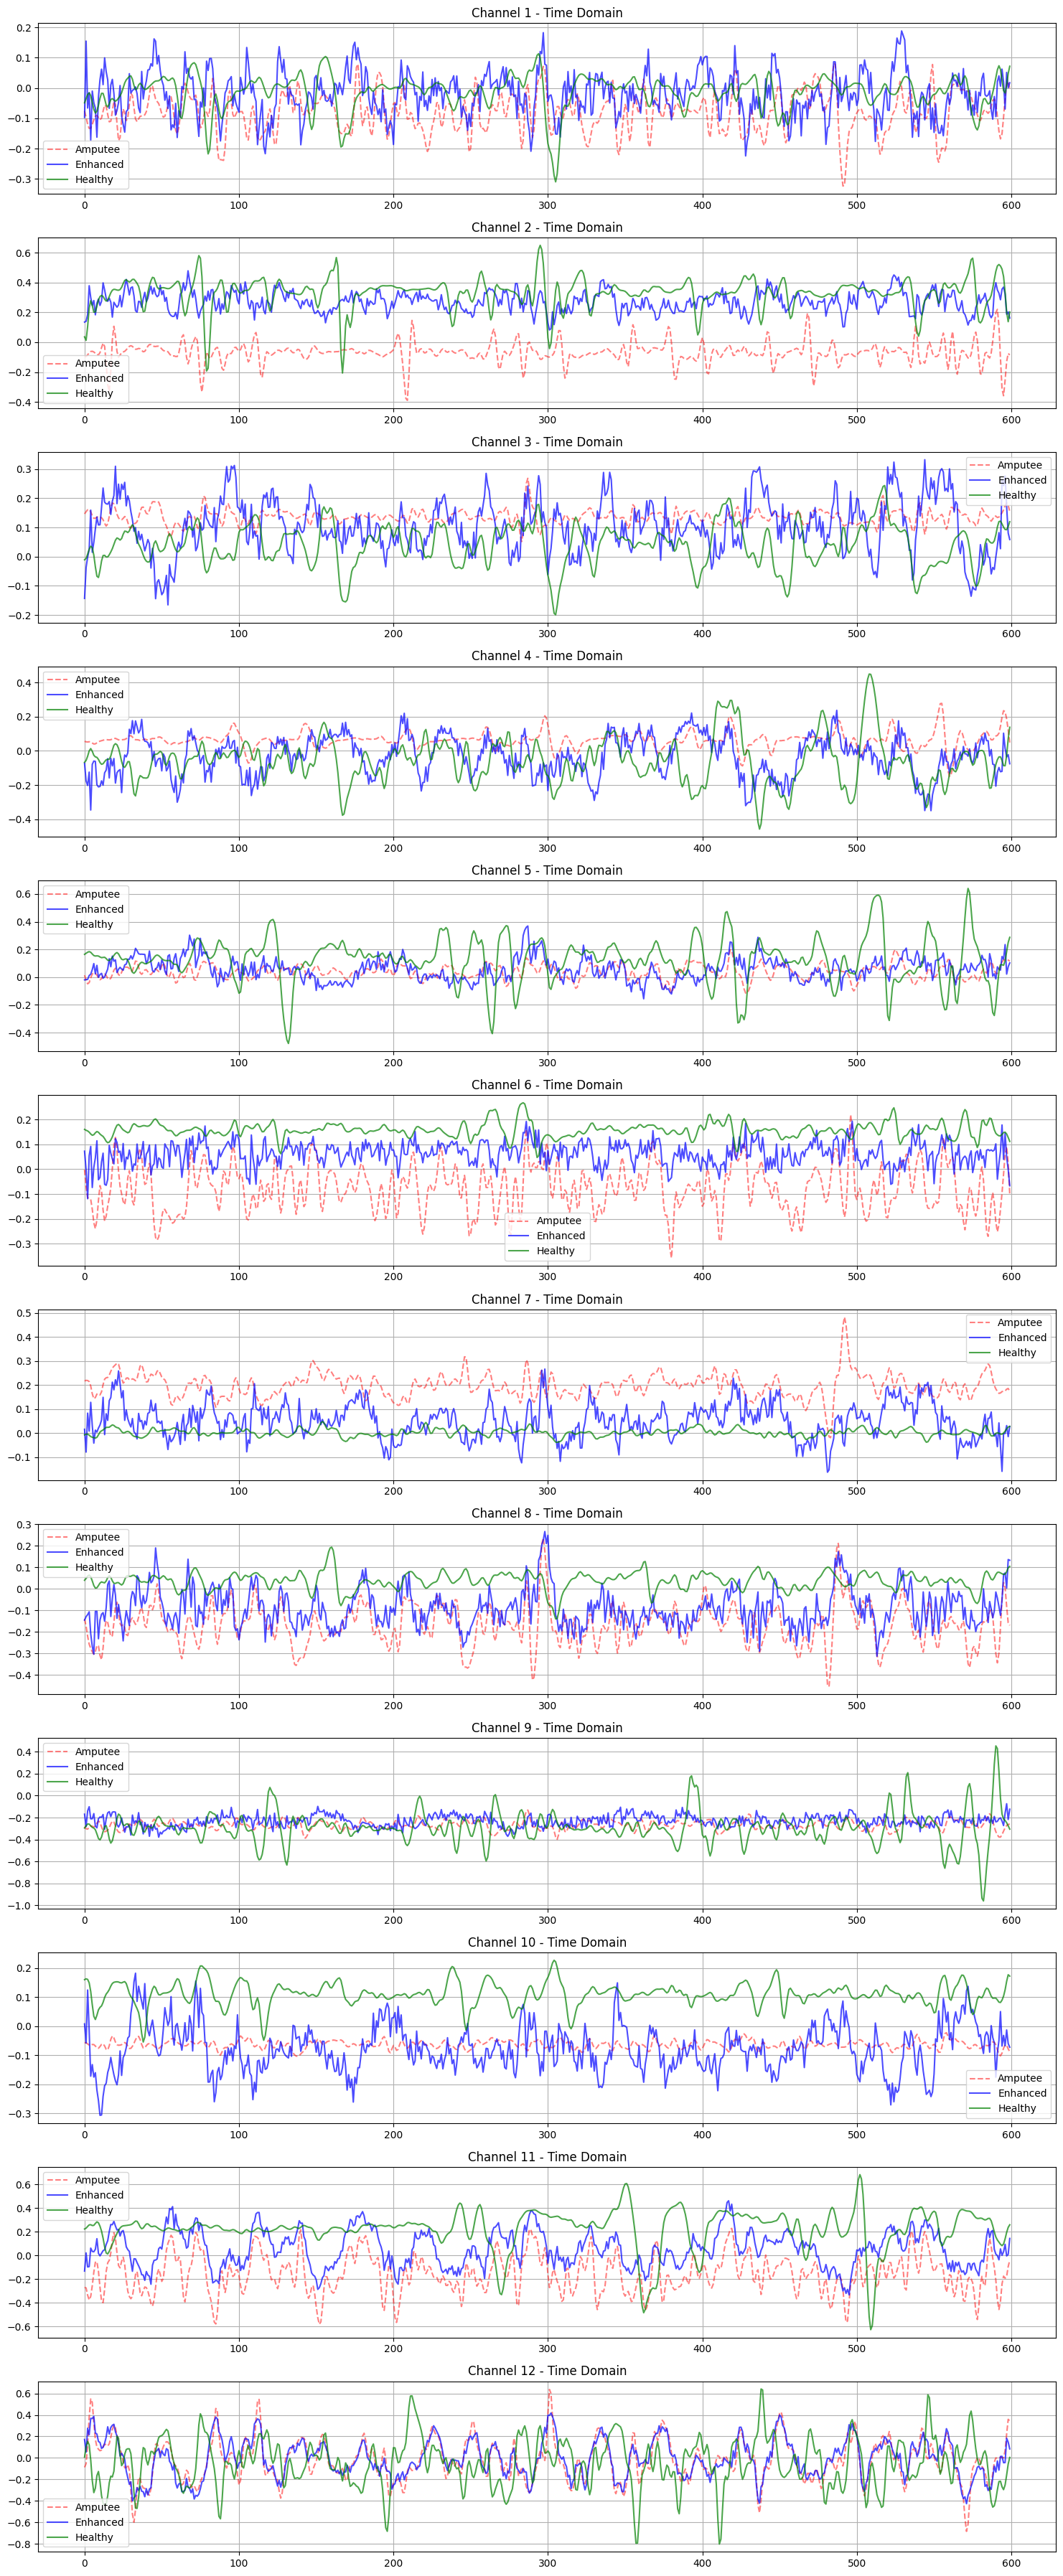

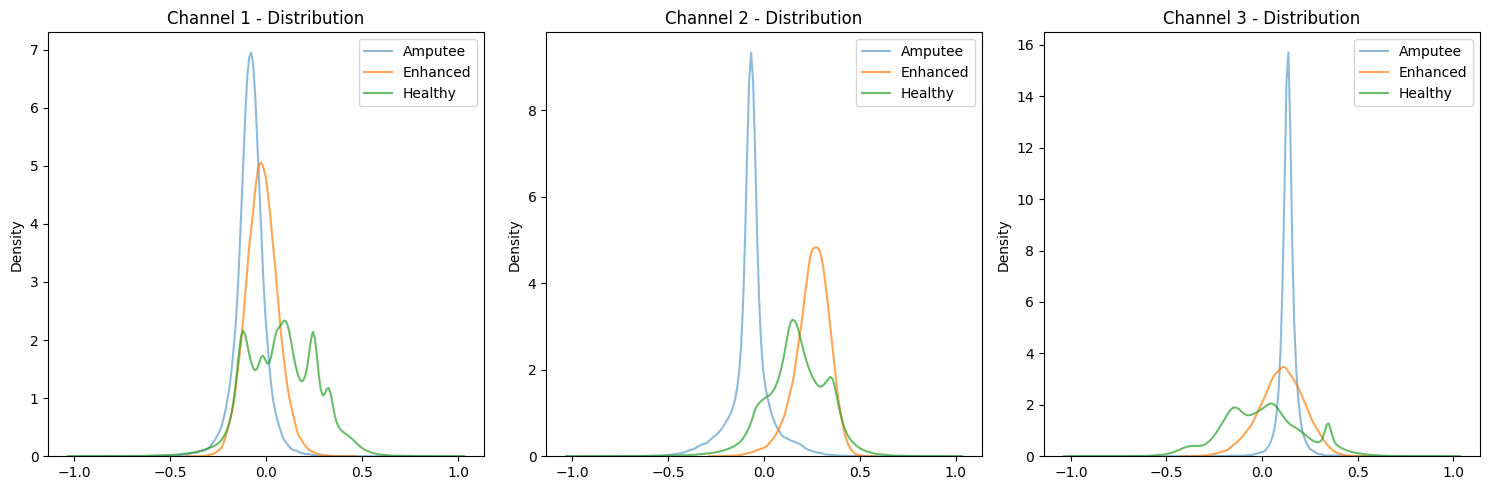

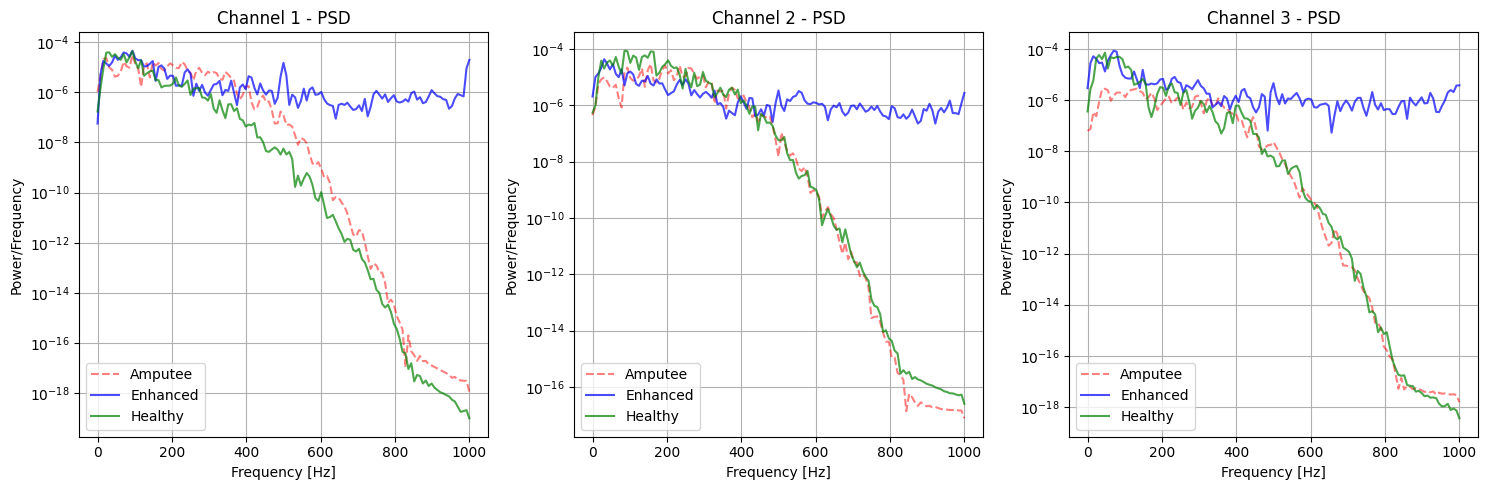


Evaluating model for Amputee 22
--------------------------------------------------
1/3 ━━━━━━━━━━━━━━━━━━━━ 5s 3s/stepWARNING:tensorflow:6 out of the last 15 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x3f5d161f0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 632ms/step


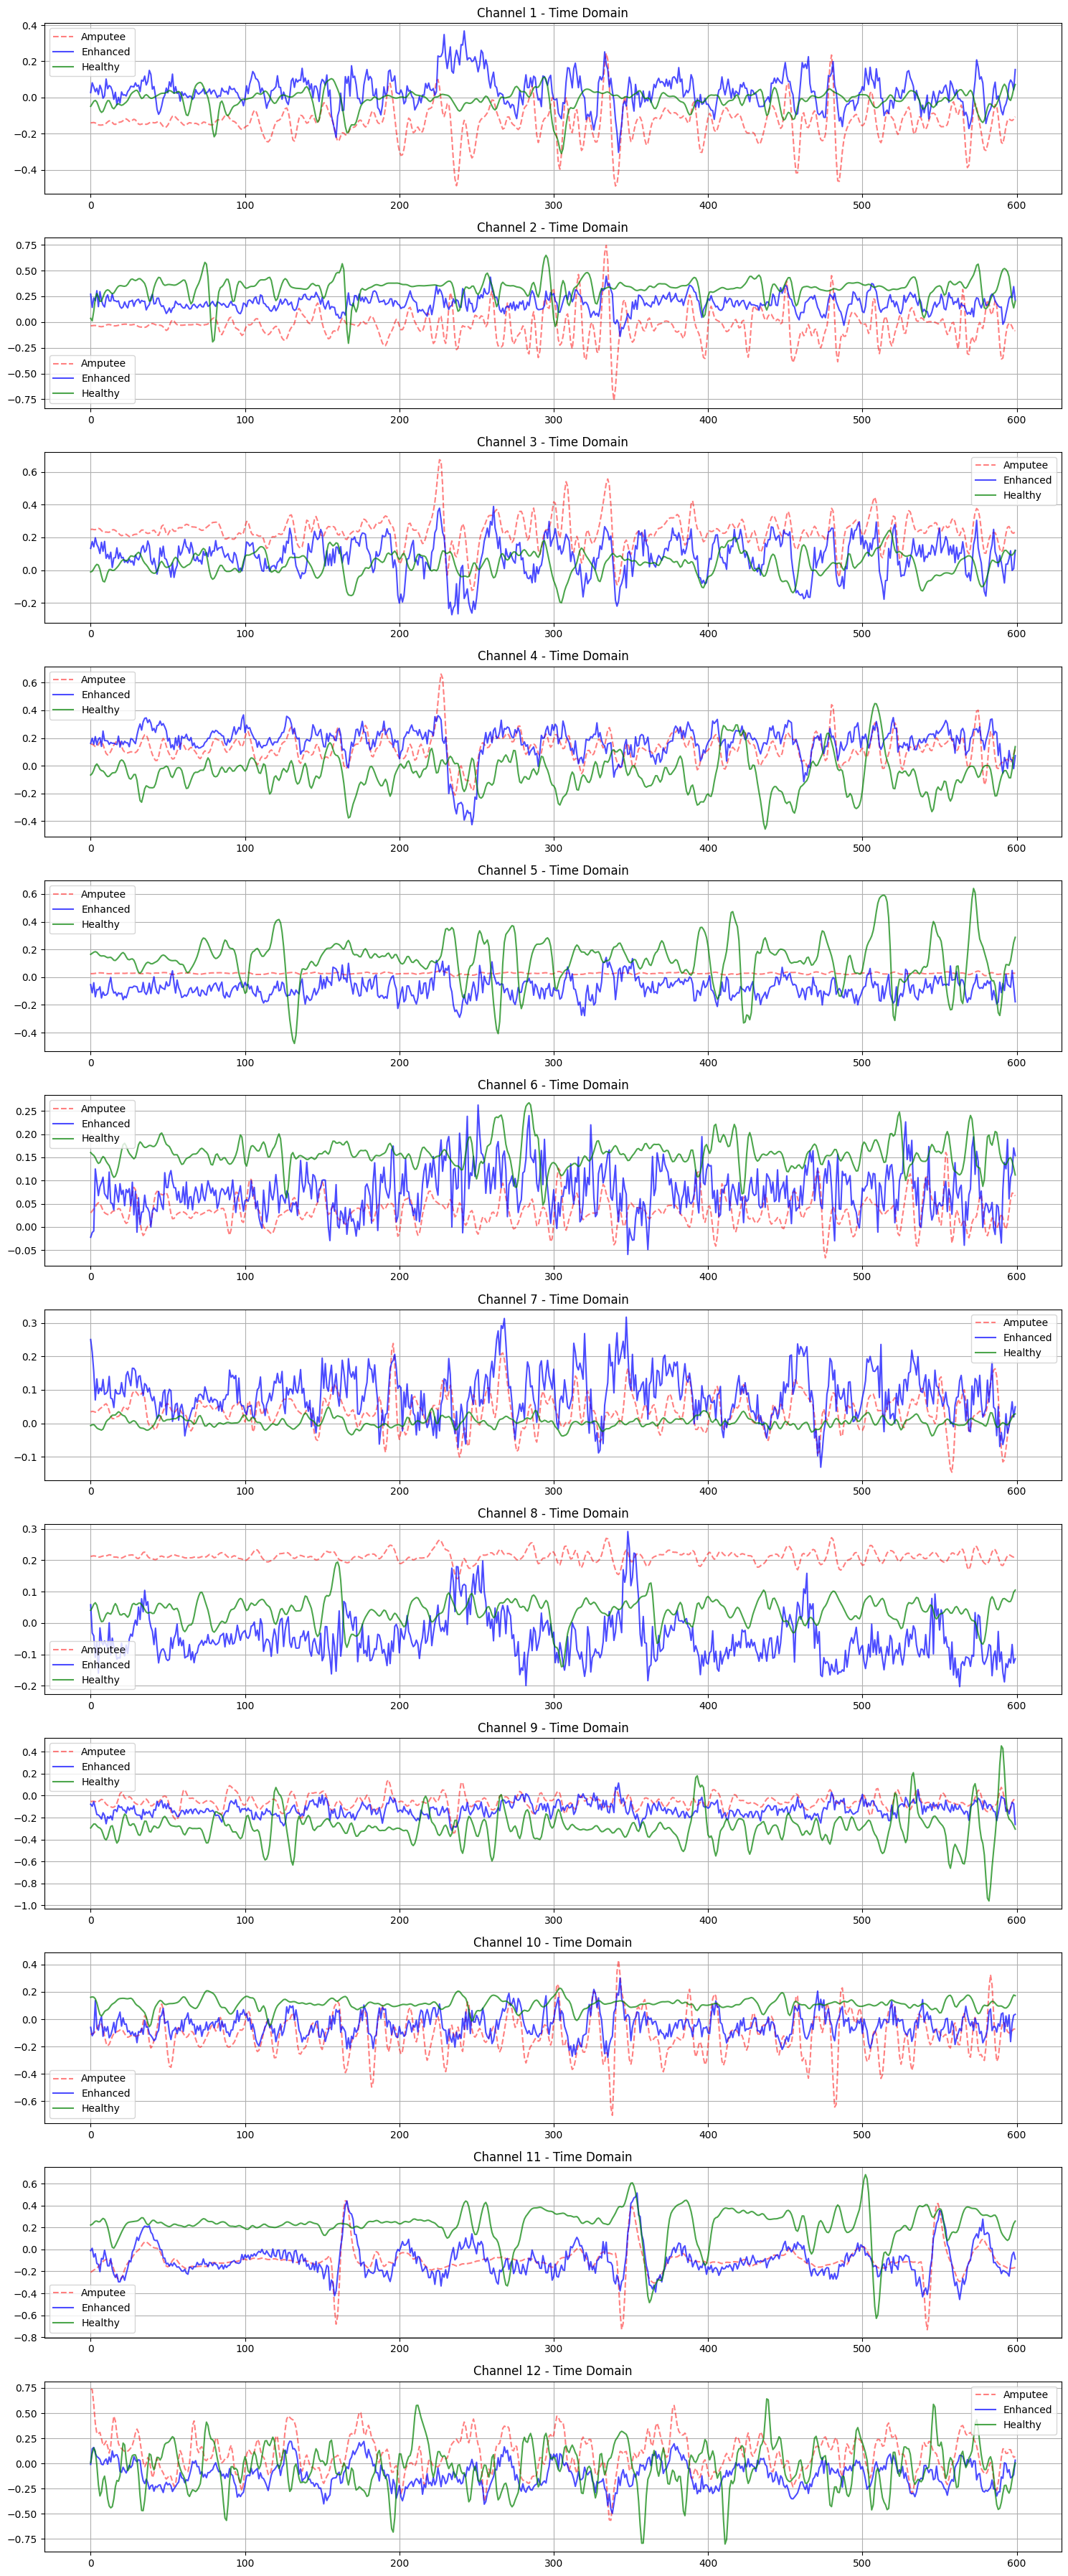

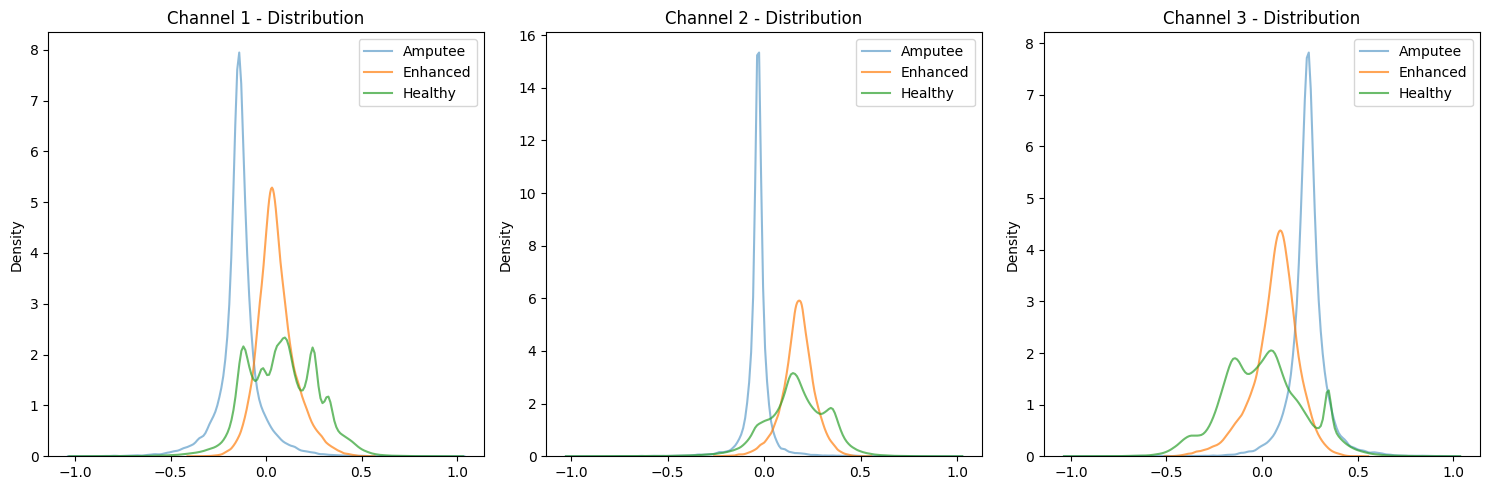

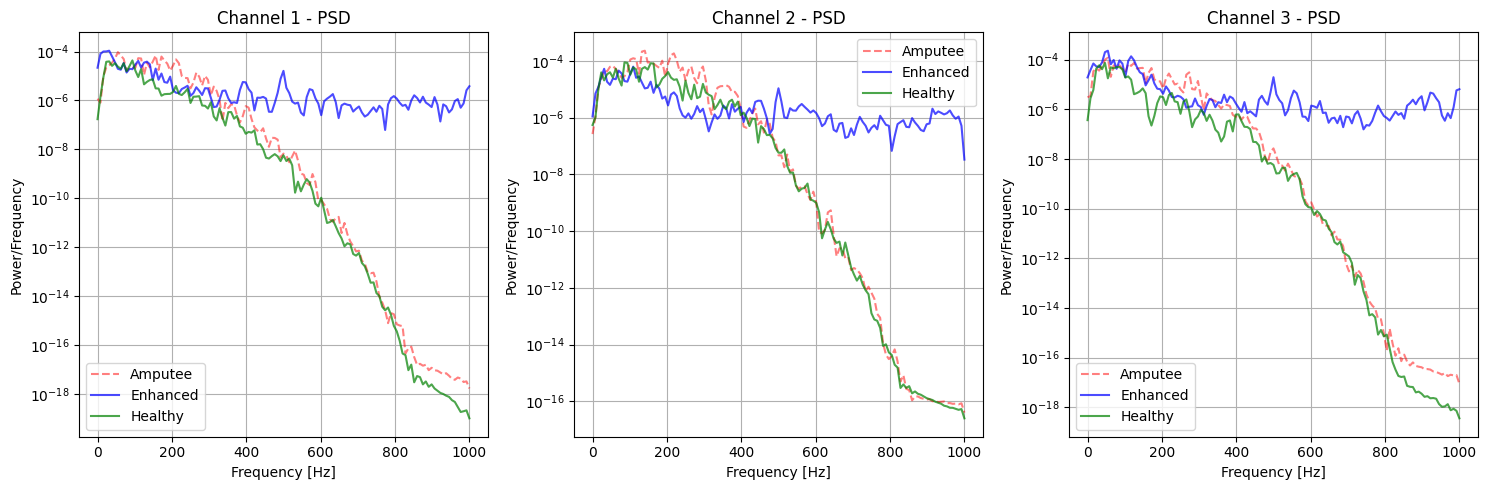

In [ ]:
def prepare_user_specific_data(processed_data, movement_idx=None):

    healthy_data = processed_data['healthy_data']
    amputee_data = processed_data['amputee_data']

    # Organize healthy data by user
    healthy_users = {}
    for entry in healthy_data:
        user_id = entry['subject_id']
        if movement_idx is None or entry['movement'] == movement_idx:
            if user_id not in healthy_users:
                healthy_users[user_id] = []
            healthy_users[user_id].append(entry['segments'])

    # Organize amputee data by user
    amputee_users = {}
    for entry in amputee_data:
        user_id = entry['subject_id']
        if movement_idx is None or entry['movement'] == movement_idx:
            if user_id not in amputee_users:
                amputee_users[user_id] = []
            amputee_users[user_id].append(entry['segments'])

    # Combine segments for each user
    healthy_user_data = {
        user_id: np.concatenate(segments, axis=0)
        for user_id, segments in healthy_users.items()
    }

    amputee_user_data = {
        user_id: np.concatenate(segments, axis=0)
        for user_id, segments in amputee_users.items()
    }

    print("\nData Organization Summary:")
    print("-" * 50)
    print(f"Number of healthy users: {len(healthy_user_data)}")
    for user_id, data in healthy_user_data.items():
        print(f"Healthy User {user_id}: {data.shape[0]} segments")

    print(f"\nNumber of amputee users: {len(amputee_user_data)}")
    for user_id, data in amputee_user_data.items():
        print(f"Amputee User {user_id}: {data.shape[0]} segments")

    return {
        'healthy_users': healthy_user_data,
        'amputee_users': amputee_user_data
    }

def train_user_specific_model(user_data, model_class, **model_params):

    trained_models = {}

    # Combine all healthy data as reference
    all_healthy_data = np.concatenate(list(user_data['healthy_users'].values()), axis=0)

    # Train separate model for each amputee
    for amputee_id, amputee_data in user_data['amputee_users'].items():
        print(f"\nTraining model for Amputee {amputee_id}")
        print("-" * 50)

        # Initialize model
        model = model_class(**model_params)

        # Train model using this amputee's data and all healthy data
        history = model.train(
            amputee_data=amputee_data,
            healthy_data=all_healthy_data,
            epochs=1000,  # Adjust as needed
            batch_size=32
        )

        trained_models[amputee_id] = {
            'model': model,
            'history': history
        }

        print(f"Training completed for Amputee {amputee_id}")

    return trained_models


# Prepare data
processed_data = load_ninapro_data(data_dir)

# Split by movement if desired
movement_idx = 18  # or None for all movements
user_data = prepare_user_specific_data(processed_data, movement_idx)

# Train models
signal_shape = (600, 12)  # Adjust based on your data
trained_models = train_user_specific_model(
    user_data,
    model_class=EMGCycleGAN,
    signal_shape=signal_shape
)

# Evaluate each model
evaluator = EMGSignalEvaluator()
for amputee_id, model_info in trained_models.items():
    print(f"\nEvaluating model for Amputee {amputee_id}")
    print("-" * 50)

    model = model_info['model']
    amputee_data = user_data['amputee_users'][amputee_id]
    healthy_data = np.concatenate(list(user_data['healthy_users'].values()), axis=0)

    # Generate enhanced signals
    enhanced_signals = model.enhance_signals(amputee_data)

    # Evaluate
    metrics = evaluator.evaluate(
        enhanced_signals,
        healthy_data,
        amputee_data
    )

    # Store evaluation results
    model_info['evaluation'] = metrics


# Classification evaluation

## Train GAN on multiple movements

In [ ]:
def prepare_multi_movement_data(processed_data, movement_indices):

    healthy_data = processed_data['healthy_data']
    amputee_data = processed_data['amputee_data']

    # Organize healthy data by user and movement
    healthy_users = {}
    for entry in healthy_data:
        user_id = entry['subject_id']
        movement = entry['movement']
        if movement in movement_indices:
            if user_id not in healthy_users:
                healthy_users[user_id] = {}
            if movement not in healthy_users[user_id]:
                healthy_users[user_id][movement] = []
            healthy_users[user_id][movement] = entry['segments']

    # Organize amputee data by user and movement
    amputee_users = {}
    for entry in amputee_data:
        user_id = entry['subject_id']
        movement = entry['movement']
        if movement in movement_indices:
            if user_id not in amputee_users:
                amputee_users[user_id] = {}
            if movement not in amputee_users[user_id]:
                amputee_users[user_id][movement] = []
            amputee_users[user_id][movement] = entry['segments']

    # Combine data and create labels
    healthy_user_data = {}
    for user_id in healthy_users:
        data_list = []
        label_list = []
        for movement in movement_indices:
            if movement in healthy_users[user_id]:
                data_list.append(healthy_users[user_id][movement])
                label_list.extend([movement] * len(healthy_users[user_id][movement]))
        if data_list:
            healthy_user_data[user_id] = {
                'data': np.concatenate(data_list, axis=0),
                'labels': np.array(label_list)
            }

    amputee_user_data = {}
    for user_id in amputee_users:
        data_list = []
        label_list = []
        for movement in movement_indices:
            if movement in amputee_users[user_id]:
                data_list.append(amputee_users[user_id][movement])
                label_list.extend([movement] * len(amputee_users[user_id][movement]))
        if data_list:
            amputee_user_data[user_id] = {
                'data': np.concatenate(data_list, axis=0),
                'labels': np.array(label_list)
            }

    print("\nData Organization Summary:")
    print("-" * 50)
    print(f"Number of healthy users: {len(healthy_user_data)}")
    for user_id, data in healthy_user_data.items():
        print(f"Healthy User {user_id}: {data['data'].shape[0]} segments")
        print(f"Movements: {np.unique(data['labels'])}")

    print(f"\nNumber of amputee users: {len(amputee_user_data)}")
    for user_id, data in amputee_user_data.items():
        print(f"Amputee User {user_id}: {data['data'].shape[0]} segments")
        print(f"Movements: {np.unique(data['labels'])}")

    return {
        'healthy_users': healthy_user_data,
        'amputee_users': amputee_user_data
    }

def prepare_data_for_classification(user_data, trained_models, movement_indices):

    healthy_segments = []
    healthy_labels = []

    # First, collect all healthy data by movement
    for movement_idx in movement_indices:
        for user_id, segments in user_data['healthy_users'].items():
            # Add segments for this movement
            healthy_segments.append(segments)
            healthy_labels.extend([movement_idx] * len(segments))

    # Convert to numpy arrays
    healthy_data = np.concatenate(healthy_segments, axis=0)
    healthy_labels = np.array(healthy_labels)

    return healthy_data, healthy_labels

def evaluate_classification(trained_models, user_data, movement_indices, test_size=0.2, random_state=42):

    results = {}

    # Collect healthy data for all movements
    healthy_segments = []
    healthy_labels = []

    print("Collecting healthy data...")
    for movement_idx in movement_indices:
        for user_id, segments in user_data['healthy_users'].items():
            healthy_segments.append(segments)
            healthy_labels.extend([movement_idx] * len(segments))

    # Convert to numpy arrays
    healthy_data = np.concatenate(healthy_segments, axis=0)
    healthy_labels = np.array(healthy_labels)

    print(f"Total healthy samples: {len(healthy_data)}")
    for movement_idx in movement_indices:
        count = np.sum(healthy_labels == movement_idx)
        print(f"Movement {movement_idx}: {count} samples")

    # Split healthy data into train and test sets
    X_train_healthy, X_test_healthy, y_train, y_test_healthy = train_test_split(
        healthy_data, healthy_labels,
        test_size=test_size,
        stratify=healthy_labels,  # Ensure balanced split
        random_state=random_state
    )

    # Extract features from training data
    print("\nExtracting features from training data...")
    X_train_features = extract_emg_features(X_train_healthy)

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_features)

    # Train SVM
    print("Training SVM classifier...")
    svm = SVC(kernel='rbf', random_state=random_state)
    svm.fit(X_train_scaled, y_train)

    # Test on healthy test set
    print("Testing on healthy data...")
    X_test_healthy_features = extract_emg_features(X_test_healthy)
    X_test_healthy_scaled = scaler.transform(X_test_healthy_features)
    healthy_accuracy = svm.score(X_test_healthy_scaled, y_test_healthy)

    # Store healthy results with confusion matrix
    y_pred_healthy = svm.predict(X_test_healthy_scaled)
    results['healthy'] = {
        'accuracy': healthy_accuracy,
        'confusion_matrix': confusion_matrix(y_test_healthy, y_pred_healthy)
    }

    print(f"\nHealthy Test Accuracy: {healthy_accuracy:.4f}")
    print("\nHealthy Confusion Matrix:")
    print(results['healthy']['confusion_matrix'])

    # Test on each amputee's data
    for amputee_id in trained_models.keys():
        print(f"\nProcessing Amputee {amputee_id}...")

        # Collect amputee data for all movements
        amputee_segments = []
        amputee_labels = []
        enhanced_segments = []

        for movement_idx in movement_indices:
            # Get original amputee data for this movement
            amputee_data = user_data['amputee_users'][amputee_id]
            amputee_segments.append(amputee_data)
            amputee_labels.extend([movement_idx] * len(amputee_data))

            # Generate enhanced data using the model
            model = trained_models[amputee_id]['model']
            enhanced_data = model.enhance_signals(amputee_data)
            enhanced_segments.append(enhanced_data)

        # Combine all movements
        amputee_data = np.concatenate(amputee_segments, axis=0)
        enhanced_data = np.concatenate(enhanced_segments, axis=0)
        amputee_labels = np.array(amputee_labels)

        print(f"Total amputee samples: {len(amputee_data)}")
        for movement_idx in movement_indices:
            count = np.sum(amputee_labels == movement_idx)
            print(f"Movement {movement_idx}: {count} samples")

        # Test amputee data
        X_amputee_features = extract_emg_features(amputee_data)
        X_amputee_scaled = scaler.transform(X_amputee_features)
        amputee_accuracy = svm.score(X_amputee_scaled, amputee_labels)
        y_pred_amputee = svm.predict(X_amputee_scaled)

        # Test enhanced data
        X_enhanced_features = extract_emg_features(enhanced_data)
        X_enhanced_scaled = scaler.transform(X_enhanced_features)
        enhanced_accuracy = svm.score(X_enhanced_scaled, amputee_labels)
        y_pred_enhanced = svm.predict(X_enhanced_scaled)

        # Store results
        results[f'amputee_{amputee_id}'] = {
            'amputee_accuracy': amputee_accuracy,
            'enhanced_accuracy': enhanced_accuracy,
            'amputee_confusion_matrix': confusion_matrix(amputee_labels, y_pred_amputee),
            'enhanced_confusion_matrix': confusion_matrix(amputee_labels, y_pred_enhanced)
        }

        print(f"\nResults for Amputee {amputee_id}:")
        print(f"Original Accuracy: {amputee_accuracy:.4f}")
        print(f"Enhanced Accuracy: {enhanced_accuracy:.4f}")
        print("\nAmputee Confusion Matrix:")
        print(results[f'amputee_{amputee_id}']['amputee_confusion_matrix'])
        print("\nEnhanced Confusion Matrix:")
        print(results[f'amputee_{amputee_id}']['enhanced_confusion_matrix'])

    return results

def visualize_results(results, movement_indices):
    """Visualize classification results"""
    # Bar plot comparing accuracies
    plt.figure(figsize=(10, 6))

    # Get accuracies
    accuracies = {
        'Healthy': results['healthy']['accuracy']
    }

    for key in results:
        if key.startswith('amputee_'):
            amputee_id = key.split('_')[1]
            accuracies[f'Amputee {amputee_id}'] = results[key]['amputee_accuracy']
            accuracies[f'Enhanced {amputee_id}'] = results[key]['enhanced_accuracy']

    # Create bar plot
    plt.bar(range(len(accuracies)), list(accuracies.values()))
    plt.xticks(range(len(accuracies)), list(accuracies.keys()), rotation=45)
    plt.ylabel('Accuracy')
    plt.title('Classification Accuracy Comparison')
    plt.tight_layout()
    plt.show()

    # Plot confusion matrices
    n_movements = len(movement_indices)

    # Plot healthy confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(results['healthy']['confusion_matrix'],
                annot=True, fmt='d',
                xticklabels=movement_indices,
                yticklabels=movement_indices)
    plt.title('Healthy Data Confusion Matrix')
    plt.xlabel('Predicted Movement')
    plt.ylabel('True Movement')
    plt.show()

    # Plot each amputee's results
    for key in results:
        if key.startswith('amputee_'):
            amputee_id = key.split('_')[1]

            # Original amputee data
            plt.figure(figsize=(6, 5))
            sns.heatmap(results[key]['amputee_confusion_matrix'],
                       annot=True, fmt='d',
                       xticklabels=movement_indices,
                       yticklabels=movement_indices)
            plt.title(f'Amputee {amputee_id} Original Data Confusion Matrix')
            plt.xlabel('Predicted Movement')
            plt.ylabel('True Movement')
            plt.show()

            # Enhanced data
            plt.figure(figsize=(6, 5))
            sns.heatmap(results[key]['enhanced_confusion_matrix'],
                       annot=True, fmt='d',
                       xticklabels=movement_indices,
                       yticklabels=movement_indices)
            plt.title(f'Amputee {amputee_id} Enhanced Data Confusion Matrix')
            plt.xlabel('Predicted Movement')
            plt.ylabel('True Movement')
            plt.show()

def run_evaluation(trained_models, user_data, movement_indices):
    """Run complete evaluation pipeline"""
    print("Starting classification evaluation...")
    print(f"Evaluating movements: {movement_indices}")

    # Run evaluation
    results = evaluate_classification(trained_models, user_data, movement_indices)

    # Visualize results
    visualize_results(results, movement_indices)

    return results


# Example usage
def run_multi_movement_evaluation(data_dir, movement_indices=[17, 18, 19, 20]):
    """Run complete evaluation with multiple movements"""
    # Load and prepare data
    processed_data = load_ninapro_data(data_dir)
    user_data = prepare_multi_movement_data(processed_data, movement_indices)

    # Train models for each movement and user
    trained_models = {}
    for amputee_id, amputee_data in user_data['amputee_users'].items():
        movement_models = {}
        for movement in np.unique(amputee_data['labels']):
            print(f"\nTraining model for Amputee {amputee_id}, Movement {movement}")

            # Filter data for this movement
            movement_mask = amputee_data['labels'] == movement
            movement_data = amputee_data['data'][movement_mask]

            # Train model
            model = EMGCycleGAN(signal_shape=(600, 12))
            history = model.train(
                amputee_data=movement_data,
                healthy_data=user_data['healthy_users'][list(user_data['healthy_users'].keys())[0]]['data'],
                epochs=200,
                batch_size=32
            )

            movement_models[movement] = {
                'model': model,
                'history': history
            }

        trained_models[amputee_id] = movement_models

    # Run classification evaluation
    print("\nStarting classification evaluation...")
    movement_indices = [18, 19, 20, 21]  # Example movements

    # Run the evaluation
    results = run_evaluation(trained_models, user_data, movement_indices)

    return results, trained_models, user_data

## SVM

In [ ]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np

def extract_emg_features(signal):
    features = []

    for segment in signal:
        segment_features = []

        for channel in range(segment.shape[1]):
            channel_data = segment[:, channel]

            # Time domain features
            mean_abs = np.mean(np.abs(channel_data))
            rms = np.sqrt(np.mean(channel_data**2))
            var = np.var(channel_data)
            wl = np.sum(np.abs(np.diff(channel_data)))  # Waveform length
            zc = np.sum(np.diff(np.signbit(channel_data).astype(int)) != 0)  # Zero crossings

            # Frequency domain features
            freqs, psd = welch(channel_data, fs=2000, nperseg=256)
            mean_freq = np.average(freqs, weights=psd)
            median_freq = freqs[np.argmax(np.cumsum(psd) >= np.sum(psd)/2)]

            # Statistical features
            skewness = stats.skew(channel_data)
            kurtosis = stats.kurtosis(channel_data)

            channel_features = [
                mean_abs, rms, var, wl, zc,
                mean_freq, median_freq,
                skewness, kurtosis
            ]

            segment_features.extend(channel_features)

        features.append(segment_features)

    return np.array(features)



In [ ]:
# Select a set of movements to include
movement_indices = [18, 19, 20, 21]  # Example movements

# Run the evaluation
results, trained_models, user_data = run_multi_movement_evaluation(
    data_dir="local_dir/EMG",
    movement_indices=movement_indices
)

In [ ]:
# Define the movements you want to evaluate
movement_indices = [18, 19, 20, 21]  # Example movements

# Run the evaluation
results = run_evaluation(trained_models, user_data, movement_indices)


## CNN


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

class EMGClassifierCNN:
    def __init__(self, input_shape, num_classes):

        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        """Build CNN model"""
        model = models.Sequential([
            # Input layer
            layers.Input(shape=self.input_shape),

            # First convolutional block
            layers.Conv1D(32, kernel_size=7, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),

            # Second convolutional block
            layers.Conv1D(64, kernel_size=5, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),

            # Third convolutional block
            layers.Conv1D(128, kernel_size=3, padding='same'),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),

            # Flatten and dense layers
            layers.Flatten(),
            layers.Dense(128, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(64, activation='relu'),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        # Compile model
        model.compile(
            optimizer='adam',
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        """Train the model"""
        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )

        # Train model
        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            verbose=1
        )

        return history

    def evaluate(self, X_test, y_test):
        """Evaluate the model"""
        return self.model.evaluate(X_test, y_test, verbose=0)

    def predict(self, X):
        """Get predictions"""
        return self.model.predict(X)

def prepare_data_for_cnn(user_data, movement_indices):
    """
    Prepare data for CNN training and evaluation
    """
    # Collect healthy data
    healthy_segments = []
    healthy_labels = []

    for movement_idx in movement_indices:
        for user_id, segments in user_data['healthy_users'].items():
            healthy_segments.append(segments)
            healthy_labels.extend([movement_idx] * len(segments))

    # Convert to numpy arrays
    healthy_data = np.concatenate(healthy_segments, axis=0)
    healthy_labels = np.array(healthy_labels)

    # Normalize data
    mean = np.mean(healthy_data)
    std = np.std(healthy_data)
    healthy_data = (healthy_data - mean) / (std + 1e-10)

    print("\nData Summary:")
    print("-" * 50)
    print(f"Healthy data shape: {healthy_data.shape}")
    print(f"Number of movements: {len(np.unique(healthy_labels))}")
    for movement_idx in movement_indices:
        count = np.sum(healthy_labels == movement_idx)
        print(f"Movement {movement_idx}: {count} samples")

    return healthy_data, healthy_labels, mean, std

def evaluate_cnn(trained_models, user_data, movement_indices, test_size=0.2, random_state=42):
    """
    Evaluate using CNN classifier
    """
    results = {}

    # Prepare data
    print("Preparing data...")
    healthy_data, healthy_labels, mean, std = prepare_data_for_cnn(
        user_data, movement_indices)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        healthy_data, healthy_labels,
        test_size=test_size,
        stratify=healthy_labels,
        random_state=random_state
    )

    # Further split training data into train and validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        stratify=y_train,
        random_state=random_state
    )

    # Initialize and train CNN
    print("\nTraining CNN classifier...")
    input_shape = (healthy_data.shape[1], healthy_data.shape[2])
    num_classes = len(np.unique(healthy_labels))

    classifier = EMGClassifierCNN(input_shape, num_classes)
    history = classifier.train(X_train, y_train, X_val, y_val)

    # Evaluate on healthy test set
    print("\nEvaluating on healthy test data...")
    healthy_loss, healthy_accuracy = classifier.evaluate(X_test, y_test)
    y_pred_healthy = classifier.predict(X_test)
    y_pred_healthy_classes = np.argmax(y_pred_healthy, axis=1)

    results['healthy'] = {
        'accuracy': healthy_accuracy,
        'confusion_matrix': confusion_matrix(y_test, y_pred_healthy_classes),
        'classification_report': classification_report(y_test, y_pred_healthy_classes)
    }

    # Evaluate on each amputee's data
    for amputee_id in trained_models.keys():
        print(f"\nProcessing Amputee {amputee_id}...")

        # Get amputee data
        amputee_data = user_data['amputee_users'][amputee_id]
        # Normalize using same parameters as healthy data
        amputee_data_norm = (amputee_data - mean) / (std + 1e-10)
        amputee_labels = np.array([movement_indices[0]] * len(amputee_data))  # Using first movement as example

        # Generate enhanced signals
        enhanced_data = trained_models[amputee_id]['model'].enhance_signals(amputee_data)
        enhanced_data_norm = (enhanced_data - mean) / (std + 1e-10)

        # Evaluate original amputee data
        amputee_loss, amputee_accuracy = classifier.evaluate(amputee_data_norm, amputee_labels)
        y_pred_amputee = classifier.predict(amputee_data_norm)
        y_pred_amputee_classes = np.argmax(y_pred_amputee, axis=1)

        # Evaluate enhanced data
        enhanced_loss, enhanced_accuracy = classifier.evaluate(enhanced_data_norm, amputee_labels)
        y_pred_enhanced = classifier.predict(enhanced_data_norm)
        y_pred_enhanced_classes = np.argmax(y_pred_enhanced, axis=1)

        results[f'amputee_{amputee_id}'] = {
            'amputee_accuracy': amputee_accuracy,
            'enhanced_accuracy': enhanced_accuracy,
            'amputee_confusion_matrix': confusion_matrix(amputee_labels, y_pred_amputee_classes),
            'enhanced_confusion_matrix': confusion_matrix(amputee_labels, y_pred_enhanced_classes),
            'amputee_classification_report': classification_report(amputee_labels, y_pred_amputee_classes),
            'enhanced_classification_report': classification_report(amputee_labels, y_pred_enhanced_classes)
        }

    return results, classifier, history

def plot_training_history(history):
    """Plot training history"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='Training')
    ax1.plot(history.history['val_accuracy'], label='Validation')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend()
    ax1.grid(True)

    # Loss plot
    ax2.plot(history.history['loss'], label='Training')
    ax2.plot(history.history['val_loss'], label='Validation')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend()
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(results, movement_indices):
    """Plot confusion matrices"""
    # Plot healthy confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(results['healthy']['confusion_matrix'],
                annot=True, fmt='d',
                xticklabels=movement_indices,
                yticklabels=movement_indices)
    plt.title('Healthy Data Confusion Matrix')
    plt.xlabel('Predicted Movement')
    plt.ylabel('True Movement')
    plt.show()

    # Plot each amputee's results
    for key in results:
        if key.startswith('amputee_'):
            amputee_id = key.split('_')[1]

            # Original amputee data
            plt.figure(figsize=(8, 6))
            sns.heatmap(results[key]['amputee_confusion_matrix'],
                       annot=True, fmt='d',
                       xticklabels=movement_indices,
                       yticklabels=movement_indices)
            plt.title(f'Amputee {amputee_id} Original Data Confusion Matrix')
            plt.xlabel('Predicted Movement')
            plt.ylabel('True Movement')
            plt.show()

            # Enhanced data
            plt.figure(figsize=(8, 6))
            sns.heatmap(results[key]['enhanced_confusion_matrix'],
                       annot=True, fmt='d',
                       xticklabels=movement_indices,
                       yticklabels=movement_indices)
            plt.title(f'Amputee {amputee_id} Enhanced Data Confusion Matrix')
            plt.xlabel('Predicted Movement')
            plt.ylabel('True Movement')
            plt.show()

def run_cnn_evaluation(trained_models, user_data, movement_indices):
    """Run complete CNN evaluation pipeline"""
    print("Starting CNN evaluation...")
    print(f"Evaluating movements: {movement_indices}")

    # Run evaluation
    results, classifier, history = evaluate_cnn(
        trained_models, user_data, movement_indices)

    # Plot training history
    plot_training_history(history)

    # Plot confusion matrices
    plot_confusion_matrices(results, movement_indices)

    # Print summary
    print("\nClassification Results Summary:")
    print("-" * 50)
    print(f"Healthy Test Accuracy: {results['healthy']['accuracy']:.4f}")

    for key in results:
        if key.startswith('amputee_'):
            amputee_id = key.split('_')[1]
            print(f"\nAmputee {amputee_id}:")
            print(f"Original Accuracy: {results[key]['amputee_accuracy']:.4f}")
            print(f"Enhanced Accuracy: {results[key]['enhanced_accuracy']:.4f}")
            improvement = (results[key]['enhanced_accuracy'] -
                         results[key]['amputee_accuracy']) * 100
            print(f"Improvement: {improvement:.2f}%")

    return results, classifier, history


movement_indices = [18, 19, 20, 21]
results, classifier, history = run_cnn_evaluation(trained_models, user_data, movement_indices)

In [ ]:
def prepare_data_for_cnn(user_data, movement_indices):
    """Prepare data with proper label preprocessing"""
    print("\nStarting data preparation...")

    # Initialize lists
    all_data = []
    all_labels = []

    # Create label mapping
    label_mapping = {movement: idx for idx, movement in enumerate(movement_indices)}
    print(f"Label mapping: {label_mapping}")

    # Collect data movement by movement
    for movement_idx in movement_indices:
        print(f"\nProcessing movement {movement_idx}")
        movement_data = []

        for user_id, segments in user_data['healthy_users'].items():
            print(f"User {user_id}: {len(segments)} segments")
            movement_data.append(segments)
            # Map original labels to 0-based indices
            all_labels.extend([label_mapping[movement_idx]] * len(segments))

        if movement_data:
            movement_array = np.concatenate(movement_data, axis=0)
            all_data.append(movement_array)
            print(f"Movement {movement_idx} total segments: {len(movement_array)}")

    # Convert to arrays
    X = np.concatenate(all_data, axis=0)
    y = np.array(all_labels)

    # Normalize
    mean = np.mean(X, axis=(0, 1), keepdims=True)
    std = np.std(X, axis=(0, 1), keepdims=True)
    X_norm = (X - mean) / (std + 1e-10)

    print("\nProcessed data summary:")
    print(f"X shape: {X_norm.shape}")
    print(f"y shape: {y.shape}")
    print(f"Unique labels: {np.unique(y)}")

    return X_norm, y, mean, std, label_mapping

class EMGClassifierCNN:
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = models.Sequential([
            # Input layer
            layers.Input(shape=self.input_shape),

            # First convolutional block
            layers.Conv1D(32, kernel_size=7, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),

            # Second convolutional block
            layers.Conv1D(64, kernel_size=5, padding='same', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.BatchNormalization(),
            layers.ReLU(),
            layers.MaxPooling1D(pool_size=2),
            layers.Dropout(0.3),

            # Flatten and dense layers
            layers.Flatten(),
            layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
            layers.Dropout(0.5),
            layers.Dense(self.num_classes, activation='softmax')
        ])

        # Use gradient clipping
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.001,
            clipnorm=1.0  # Clip gradients
        )

        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        model.summary()
        return model

    def train(self, X_train, y_train, X_val, y_val, epochs=100, batch_size=32):
        print("\nStarting training:")
        print(f"Training data shape: {X_train.shape}")
        print(f"Training labels shape: {y_train.shape}")
        print(f"Training labels range: {np.min(y_train)} - {np.max(y_train)}")

        # Early stopping
        early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            restore_best_weights=True
        )

        # Reduce learning rate on plateau
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5,
            min_lr=1e-6
        )

        history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=[early_stopping, reduce_lr],
            verbose=1
        )

        return history

def run_evaluation(trained_models, user_data, movement_indices):
    """Run complete evaluation pipeline"""
    print("Starting CNN evaluation...")

    # Prepare data with proper label mapping
    X, y, mean, std, label_mapping = prepare_data_for_cnn(user_data, movement_indices)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=0.2,
        stratify=y,
        random_state=42
    )

    X_train, X_val, y_train, y_val = train_test_split(
        X_train, y_train,
        test_size=0.2,
        stratify=y_train,
        random_state=42
    )

    # Initialize and train CNN
    classifier = EMGClassifierCNN(
        input_shape=(X.shape[1], X.shape[2]),
        num_classes=len(movement_indices)
    )

    history = classifier.train(
        X_train, y_train,
        X_val, y_val,
        epochs=50,  # Reduced for testing
        batch_size=32
    )

    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Evaluate on test set
    test_loss, test_acc = classifier.model.evaluate(X_test, y_test)
    print(f"\nTest accuracy: {test_acc:.4f}")

    return classifier, history, label_mapping


classifier, history, label_mapping = run_evaluation(trained_models, user_data, movement_indices)